In [1]:
import sys 
import matplotlib.pyplot as plt
import logic.pulsed.pulse_objects as po
import time
#poi_m = poimanagerlogic
pml = pulsedmeasurementlogic
import os
sys.path.insert(0, 'C:/qudi/qudi/notebooks/AWG8190a')
import awg8190a_backend36
import waveforms88
#jupyter notebook --NotebookApp.iopub_data_rate_limit=1.0e10

In [2]:
def optimize():
    confocal.refocus_clicked()
    time.sleep(1)
    while optimizerlogic.module_state()=='locked':
       time.sleep(1)
    return 

In [25]:
class qudi_pulsed_measurements:

    def __init__(self, awg_sync_pause = 4e-6, laser_on = 3e-6, counter_off = 50e-9, relaxation_pause = 5e-6):

        self.awg_sync_pause = awg_sync_pause
        self.laser_on = laser_on
        self.counter_off = counter_off
        self.relaxation_pause = relaxation_pause

    def make_rabi_pulse_block(self, tau, tau_step, step_number):
        ele = []
        
        d_ch = {'d_ch1': False, 'd_ch2': False, 'd_ch4': False, 'd_ch3': False, 'd_ch5': True, 'd_ch6': False, 'd_ch7': False, 'd_ch8': False}
        ele.append(po.PulseBlockElement(init_length_s=10*1e-9, increment_s=0, pulse_function=None, digital_high=d_ch, laser_on=False))    
    
        d_ch = {'d_ch1': False, 'd_ch2': False, 'd_ch4': False, 'd_ch3': True, 'd_ch5': False, 'd_ch6': False, 'd_ch7': False, 'd_ch8': False}
        ele.append(po.PulseBlockElement(init_length_s=tau, increment_s=tau_step, pulse_function=None, digital_high=d_ch, laser_on=False))
            
        d_ch = {'d_ch1': False, 'd_ch2': False, 'd_ch4': False, 'd_ch3': False, 'd_ch5': False, 'd_ch6': False, 'd_ch7': False, 'd_ch8': False}
        ele.append(po.PulseBlockElement(init_length_s=self.awg_sync_pause, increment_s=0, pulse_function=None, digital_high=d_ch, laser_on=False))

        d_ch = {'d_ch1': True, 'd_ch2': True, 'd_ch4': False, 'd_ch3': False, 'd_ch5': False, 'd_ch6': False, 'd_ch7': False, 'd_ch8': False}
        ele.append(po.PulseBlockElement(init_length_s=self.laser_on, increment_s=0, pulse_function=None, digital_high=d_ch, laser_on=False))

        d_ch = {'d_ch1': False, 'd_ch2': True, 'd_ch4': False, 'd_ch3': False, 'd_ch5': False, 'd_ch6': False, 'd_ch7': False, 'd_ch8': False}
        ele.append(po.PulseBlockElement(init_length_s=self.counter_off, increment_s=0, pulse_function=None, digital_high=d_ch, laser_on=False))

        d_ch = {'d_ch1': False, 'd_ch2': False, 'd_ch4': False, 'd_ch3': False, 'd_ch5': False, 'd_ch6': False, 'd_ch7': False, 'd_ch8': False}
        ele.append(po.PulseBlockElement(init_length_s=self.relaxation_pause, increment_s=0, pulse_function=None, digital_high=d_ch, laser_on=False))
        
        pulse_block = po.PulseBlock(name=f'rabi_qudi', element_list=ele)
        
        return pulse_block

    def upload_rabi_ensemble(self, tau, tau_step, step_number, pulse_fnt):
        pulse = pulse_fnt(tau, tau_step, step_number)
        sequencegeneratorlogic.save_block(pulse)

        bl = [(pulse.name,step_number-1)]
        auto_pulse_CW = po.PulseBlockEnsemble(name=f'rabi_qudi', block_list=bl, rotating_frame=False)

        ensemble = auto_pulse_CW
        ensemblename = auto_pulse_CW.name
        sequencegeneratorlogic.save_ensemble(ensemble)
        ret,_,_ = sequencegeneratorlogic.sample_pulse_block_ensemble(ensemblename)
        sequencegeneratorlogic.load_ensemble(ensemblename)
        return ret

    def rabi(self, tau, tau_step, step_number):
        pulsedmasterlogic.set_ext_microwave_settings(use_ext_microwave=False)

        err = self.upload_rabi_ensemble(tau, tau_step, step_number, self.make_rabi_pulse_block)

        tau_list = np.linspace(tau*1e9, tau*1e9 + (step_number-1)*tau_step*1e9, step_number)*1e-9
        pulsedmasterlogic.set_measurement_settings(invoke_settings=False, 
                                                controlled_variable=tau_list,
                                                number_of_lasers=step_number, 
                                                laser_ignore_list=[], 
                                                alternating=False, 
                                                units=('s', 'arb. u.'))
        time.sleep(0.5)
        pulsedmasterlogic.set_alternative_data_type('None')
        time.sleep(0.5)
        
    def make_pulsed_ODMR_pulse_block(self, pi_pulse):
        ele = []
        
        d_ch = {'d_ch1': False, 'd_ch2': False, 'd_ch4': False, 'd_ch3': False, 'd_ch5': True, 'd_ch6': False, 'd_ch7': False, 'd_ch8': False}
        ele.append(po.PulseBlockElement(init_length_s=10e-9, increment_s=0, pulse_function=None, digital_high=d_ch, laser_on=False))    
    
        d_ch = {'d_ch1': False, 'd_ch2': False, 'd_ch4': False, 'd_ch3': True, 'd_ch5': False, 'd_ch6': False, 'd_ch7': False, 'd_ch8': False}
        ele.append(po.PulseBlockElement(init_length_s=pi_pulse*1e-9, increment_s=0, pulse_function=None, digital_high=d_ch, laser_on=False))
            
        d_ch = {'d_ch1': False, 'd_ch2': False, 'd_ch4': False, 'd_ch3': False, 'd_ch5': False, 'd_ch6': False, 'd_ch7': False, 'd_ch8': False}
        ele.append(po.PulseBlockElement(init_length_s=self.awg_sync_pause, increment_s=0, pulse_function=None, digital_high=d_ch, laser_on=False))

        d_ch = {'d_ch1': True, 'd_ch2': True, 'd_ch4': False, 'd_ch3': False, 'd_ch5': False, 'd_ch6': False, 'd_ch7': False, 'd_ch8': False}
        ele.append(po.PulseBlockElement(init_length_s=self.laser_on, increment_s=0, pulse_function=None, digital_high=d_ch, laser_on=False))

        d_ch = {'d_ch1': False, 'd_ch2': True, 'd_ch4': False, 'd_ch3': False, 'd_ch5': False, 'd_ch6': False, 'd_ch7': False, 'd_ch8': False}
        ele.append(po.PulseBlockElement(init_length_s=self.counter_off, increment_s=0, pulse_function=None, digital_high=d_ch, laser_on=False))

        d_ch = {'d_ch1': False, 'd_ch2': False, 'd_ch4': False, 'd_ch3': False, 'd_ch5': False, 'd_ch6': False, 'd_ch7': False, 'd_ch8': False}
        ele.append(po.PulseBlockElement(init_length_s=self.relaxation_pause, increment_s=0, pulse_function=None, digital_high=d_ch, laser_on=False))
        
        pulse_block = po.PulseBlock(name=f'pulsed_ODMR_qudi', element_list=ele)
        
        return pulse_block
    
    def upload_pulsed_ODMR_ensemble(self, freq_list, pi_pulse, pulse_fnt):
        pulse = pulse_fnt(pi_pulse)
        sequencegeneratorlogic.save_block(pulse)

        bl = [(pulse.name,len(freq_list)-1)]
        auto_pulse_CW = po.PulseBlockEnsemble(name=f'pulsed_ODMR_qudi', block_list=bl, rotating_frame=False)

        ensemble = auto_pulse_CW
        ensemblename = auto_pulse_CW.name
        sequencegeneratorlogic.save_ensemble(ensemble)
        ret,_,_ = sequencegeneratorlogic.sample_pulse_block_ensemble(ensemblename)
        sequencegeneratorlogic.load_ensemble(ensemblename)
        return ret
    
    def pulsed_ODMR(self, freq_start, freq_stop, freq_step, pi_pulse):
        pulsedmasterlogic.set_ext_microwave_settings(use_ext_microwave=False)
        freq_list = np.arange(freq_start, freq_stop+freq_step, freq_step)
        if not ((freq_stop-freq_start)/freq_step)%1 ==0:
            freq_list = freq_list[:-1]
        err = self.upload_pulsed_ODMR_ensemble(freq_list, pi_pulse, self.make_pulsed_ODMR_pulse_block)
        pulsedmasterlogic.set_measurement_settings(invoke_settings=False, 
                                                controlled_variable=freq_list,
                                                number_of_lasers=len(freq_list), 
                                                laser_ignore_list=[], 
                                                alternating=False, 
                                                units=('Hz', 'arb. u.'))
        time.sleep(0.5)
        pulsedmasterlogic.set_alternative_data_type('None')
        time.sleep(0.5)
        
    def make_FID_pulse_block(self, tau, tau_step, step_number, pi_half_pulse, pi_three_half_pulse, alternating):
        ele = []
        
        d_ch = {'d_ch1': False, 'd_ch2': False, 'd_ch4': False, 'd_ch3': False, 'd_ch5': True, 'd_ch6': False, 'd_ch7': False, 'd_ch8': False}
        ele.append(po.PulseBlockElement(init_length_s=10*1e-9, increment_s=0, pulse_function=None, digital_high=d_ch, laser_on=False))    
    
        d_ch = {'d_ch1': False, 'd_ch2': False, 'd_ch4': False, 'd_ch3': True, 'd_ch5': False, 'd_ch6': False, 'd_ch7': False, 'd_ch8': False}
        ele.append(po.PulseBlockElement(init_length_s=pi_half_pulse*1e-9, increment_s=0, pulse_function=None, digital_high=d_ch, laser_on=False))
        
        d_ch = {'d_ch1': False, 'd_ch2': False, 'd_ch4': False, 'd_ch3': False, 'd_ch5': False, 'd_ch6': False, 'd_ch7': False, 'd_ch8': False}
        ele.append(po.PulseBlockElement(init_length_s=tau, increment_s=tau_step, pulse_function=None, digital_high=d_ch, laser_on=False))
        
        d_ch = {'d_ch1': False, 'd_ch2': False, 'd_ch4': False, 'd_ch3': True, 'd_ch5': False, 'd_ch6': False, 'd_ch7': False, 'd_ch8': False}
        ele.append(po.PulseBlockElement(init_length_s=pi_half_pulse*1e-9, increment_s=0, pulse_function=None, digital_high=d_ch, laser_on=False))
            
        d_ch = {'d_ch1': False, 'd_ch2': False, 'd_ch4': False, 'd_ch3': False, 'd_ch5': False, 'd_ch6': False, 'd_ch7': False, 'd_ch8': False}
        ele.append(po.PulseBlockElement(init_length_s=self.awg_sync_pause, increment_s=0, pulse_function=None, digital_high=d_ch, laser_on=False))

        d_ch = {'d_ch1': True, 'd_ch2': True, 'd_ch4': False, 'd_ch3': False, 'd_ch5': False, 'd_ch6': False, 'd_ch7': False, 'd_ch8': False}
        ele.append(po.PulseBlockElement(init_length_s=self.laser_on, increment_s=0, pulse_function=None, digital_high=d_ch, laser_on=True))

        d_ch = {'d_ch1': False, 'd_ch2': True, 'd_ch4': False, 'd_ch3': False, 'd_ch5': False, 'd_ch6': False, 'd_ch7': False, 'd_ch8': False}
        ele.append(po.PulseBlockElement(init_length_s=self.counter_off, increment_s=0, pulse_function=None, digital_high=d_ch, laser_on=False))

        d_ch = {'d_ch1': False, 'd_ch2': False, 'd_ch4': False, 'd_ch3': False, 'd_ch5': False, 'd_ch6': False, 'd_ch7': False, 'd_ch8': False}
        ele.append(po.PulseBlockElement(init_length_s=self.relaxation_pause, increment_s=0, pulse_function=None, digital_high=d_ch, laser_on=False))
        
        if alternating:
            d_ch = {'d_ch1': False, 'd_ch2': False, 'd_ch4': False, 'd_ch3': True, 'd_ch5': False, 'd_ch6': False, 'd_ch7': False, 'd_ch8': False}
            ele.append(po.PulseBlockElement(init_length_s=pi_half_pulse*1e-9, increment_s=0, pulse_function=None, digital_high=d_ch, laser_on=False))

            d_ch = {'d_ch1': False, 'd_ch2': False, 'd_ch4': False, 'd_ch3': False, 'd_ch5': False, 'd_ch6': False, 'd_ch7': False, 'd_ch8': False}
            ele.append(po.PulseBlockElement(init_length_s=tau, increment_s=tau_step, pulse_function=None, digital_high=d_ch, laser_on=False))

            d_ch = {'d_ch1': False, 'd_ch2': False, 'd_ch4': False, 'd_ch3': True, 'd_ch5': False, 'd_ch6': False, 'd_ch7': False, 'd_ch8': False}
            ele.append(po.PulseBlockElement(init_length_s=pi_three_half_pulse*1e-9, increment_s=0, pulse_function=None, digital_high=d_ch, laser_on=False))

            d_ch = {'d_ch1': False, 'd_ch2': False, 'd_ch4': False, 'd_ch3': False, 'd_ch5': False, 'd_ch6': False, 'd_ch7': False, 'd_ch8': False}
            ele.append(po.PulseBlockElement(init_length_s=self.awg_sync_pause, increment_s=0, pulse_function=None, digital_high=d_ch, laser_on=False))

            d_ch = {'d_ch1': True, 'd_ch2': True, 'd_ch4': False, 'd_ch3': False, 'd_ch5': False, 'd_ch6': False, 'd_ch7': False, 'd_ch8': False}
            ele.append(po.PulseBlockElement(init_length_s=self.laser_on, increment_s=0, pulse_function=None, digital_high=d_ch, laser_on=False))

            d_ch = {'d_ch1': False, 'd_ch2': True, 'd_ch4': False, 'd_ch3': False, 'd_ch5': False, 'd_ch6': False, 'd_ch7': False, 'd_ch8': False}
            ele.append(po.PulseBlockElement(init_length_s=self.counter_off, increment_s=0, pulse_function=None, digital_high=d_ch, laser_on=True))

            d_ch = {'d_ch1': False, 'd_ch2': False, 'd_ch4': False, 'd_ch3': False, 'd_ch5': False, 'd_ch6': False, 'd_ch7': False, 'd_ch8': False}
            ele.append(po.PulseBlockElement(init_length_s=self.relaxation_pause, increment_s=0, pulse_function=None, digital_high=d_ch, laser_on=False))

        pulse_block = po.PulseBlock(name=f'FID_qudi', element_list=ele)
        
        return pulse_block

    def upload_FID_ensemble(self, tau, tau_step, step_number, pi_half_pulse, pi_three_half_pulse, alternating, pulse_fnt):
        pulse = pulse_fnt(tau, tau_step, step_number, pi_half_pulse, pi_three_half_pulse, alternating)
        sequencegeneratorlogic.save_block(pulse)

        bl = [(pulse.name,step_number-1)]
        auto_pulse_CW = po.PulseBlockEnsemble(name=f'FID_qudi', block_list=bl, rotating_frame=False)

        ensemble = auto_pulse_CW
        ensemblename = auto_pulse_CW.name
        sequencegeneratorlogic.save_ensemble(ensemble)
        ret,_,_ = sequencegeneratorlogic.sample_pulse_block_ensemble(ensemblename)
        sequencegeneratorlogic.load_ensemble(ensemblename)
        return ret

    def FID(self, tau, tau_step, step_number, pi_half_pulse, pi_three_half_pulse, alternating):
        pulsedmasterlogic.set_ext_microwave_settings(use_ext_microwave=False)

        err = self.upload_FID_ensemble(tau, tau_step, step_number, pi_half_pulse, pi_three_half_pulse, alternating, self.make_FID_pulse_block)
        
        variable_start = tau*1e9
        variable_end = (tau+tau_step*(step_number))*1e9
        variable_step = tau_step*1e9
        if alternating:
            laser_number = 2*step_number
        else:
            laser_number = step_number
        pulsedmasterlogic.set_measurement_settings(invoke_settings=False, 
                                                controlled_variable=np.arange(variable_start,variable_end,variable_step)*1e-9,
                                                number_of_lasers=laser_number, 
                                                laser_ignore_list=[], 
                                                alternating=alternating, 
                                                units=('s', 'arb. u.'))
        time.sleep(0.5)
        if alternating:
            pulsedmasterlogic.set_alternative_data_type('Delta')
        else:
            pulsedmasterlogic.set_alternative_data_type('None')
        time.sleep(0.5)
        
    def make_hahn_echo_pulse_block(self, tau_start, tau_step, pi_half_pulse,  pi_pulse, pi_three_half_pulse, alternating):
        ele = []
        
        d_ch = {'d_ch1': False, 'd_ch2': False, 'd_ch4': False, 'd_ch3': False, 'd_ch5': True, 'd_ch6': False, 'd_ch7': False, 'd_ch8': False}
        ele.append(po.PulseBlockElement(init_length_s=10*1e-9, increment_s=0, pulse_function=None, digital_high=d_ch, laser_on=False))    
    
        d_ch = {'d_ch1': False, 'd_ch2': False, 'd_ch4': False, 'd_ch3': True, 'd_ch5': False, 'd_ch6': False, 'd_ch7': False, 'd_ch8': False}
        ele.append(po.PulseBlockElement(init_length_s=pi_half_pulse*1e-9, increment_s=0, pulse_function=None, digital_high=d_ch, laser_on=False))
        
        d_ch = {'d_ch1': False, 'd_ch2': False, 'd_ch4': False, 'd_ch3': False, 'd_ch5': False, 'd_ch6': False, 'd_ch7': False, 'd_ch8': False}
        ele.append(po.PulseBlockElement(init_length_s=tau_start/2, increment_s=tau_step/2, pulse_function=None, digital_high=d_ch, laser_on=False))
        
        d_ch = {'d_ch1': False, 'd_ch2': False, 'd_ch4': False, 'd_ch3': True, 'd_ch5': False, 'd_ch6': False, 'd_ch7': False, 'd_ch8': False}
        ele.append(po.PulseBlockElement(init_length_s=pi_pulse*1e-9, increment_s=0, pulse_function=None, digital_high=d_ch, laser_on=False))
        
        d_ch = {'d_ch1': False, 'd_ch2': False, 'd_ch4': False, 'd_ch3': False, 'd_ch5': False, 'd_ch6': False, 'd_ch7': False, 'd_ch8': False}
        ele.append(po.PulseBlockElement(init_length_s=tau_start/2, increment_s=tau_step/2, pulse_function=None, digital_high=d_ch, laser_on=False))
        
        d_ch = {'d_ch1': False, 'd_ch2': False, 'd_ch4': False, 'd_ch3': True, 'd_ch5': False, 'd_ch6': False, 'd_ch7': False, 'd_ch8': False}
        ele.append(po.PulseBlockElement(init_length_s=pi_half_pulse*1e-9, increment_s=0, pulse_function=None, digital_high=d_ch, laser_on=False))
            
        d_ch = {'d_ch1': False, 'd_ch2': False, 'd_ch4': False, 'd_ch3': False, 'd_ch5': False, 'd_ch6': False, 'd_ch7': False, 'd_ch8': False}
        ele.append(po.PulseBlockElement(init_length_s=self.awg_sync_pause, increment_s=0, pulse_function=None, digital_high=d_ch, laser_on=False))

        d_ch = {'d_ch1': True, 'd_ch2': True, 'd_ch4': False, 'd_ch3': False, 'd_ch5': False, 'd_ch6': False, 'd_ch7': False, 'd_ch8': False}
        ele.append(po.PulseBlockElement(init_length_s=self.laser_on, increment_s=0, pulse_function=None, digital_high=d_ch, laser_on=True))

        d_ch = {'d_ch1': False, 'd_ch2': True, 'd_ch4': False, 'd_ch3': False, 'd_ch5': False, 'd_ch6': False, 'd_ch7': False, 'd_ch8': False}
        ele.append(po.PulseBlockElement(init_length_s=self.counter_off, increment_s=0, pulse_function=None, digital_high=d_ch, laser_on=False))

        d_ch = {'d_ch1': False, 'd_ch2': False, 'd_ch4': False, 'd_ch3': False, 'd_ch5': False, 'd_ch6': False, 'd_ch7': False, 'd_ch8': False}
        ele.append(po.PulseBlockElement(init_length_s=self.relaxation_pause, increment_s=0, pulse_function=None, digital_high=d_ch, laser_on=False))
        
        if alternating:
            d_ch = {'d_ch1': False, 'd_ch2': False, 'd_ch4': False, 'd_ch3': True, 'd_ch5': False, 'd_ch6': False, 'd_ch7': False, 'd_ch8': False}
            ele.append(po.PulseBlockElement(init_length_s=pi_half_pulse*1e-9, increment_s=0, pulse_function=None, digital_high=d_ch, laser_on=False))

            d_ch = {'d_ch1': False, 'd_ch2': False, 'd_ch4': False, 'd_ch3': False, 'd_ch5': False, 'd_ch6': False, 'd_ch7': False, 'd_ch8': False}
            ele.append(po.PulseBlockElement(init_length_s=tau_start/2, increment_s=tau_step/2, pulse_function=None, digital_high=d_ch, laser_on=False))
            
            d_ch = {'d_ch1': False, 'd_ch2': False, 'd_ch4': False, 'd_ch3': True, 'd_ch5': False, 'd_ch6': False, 'd_ch7': False, 'd_ch8': False}
            ele.append(po.PulseBlockElement(init_length_s=pi_pulse*1e-9, increment_s=0, pulse_function=None, digital_high=d_ch, laser_on=False))
            
            d_ch = {'d_ch1': False, 'd_ch2': False, 'd_ch4': False, 'd_ch3': False, 'd_ch5': False, 'd_ch6': False, 'd_ch7': False, 'd_ch8': False}
            ele.append(po.PulseBlockElement(init_length_s=tau_start/2, increment_s=tau_step/2, pulse_function=None, digital_high=d_ch, laser_on=False))

            d_ch = {'d_ch1': False, 'd_ch2': False, 'd_ch4': False, 'd_ch3': True, 'd_ch5': False, 'd_ch6': False, 'd_ch7': False, 'd_ch8': False}
            ele.append(po.PulseBlockElement(init_length_s=pi_three_half_pulse*1e-9, increment_s=0, pulse_function=None, digital_high=d_ch, laser_on=False))

            d_ch = {'d_ch1': False, 'd_ch2': False, 'd_ch4': False, 'd_ch3': False, 'd_ch5': False, 'd_ch6': False, 'd_ch7': False, 'd_ch8': False}
            ele.append(po.PulseBlockElement(init_length_s=self.awg_sync_pause, increment_s=0, pulse_function=None, digital_high=d_ch, laser_on=False))

            d_ch = {'d_ch1': True, 'd_ch2': True, 'd_ch4': False, 'd_ch3': False, 'd_ch5': False, 'd_ch6': False, 'd_ch7': False, 'd_ch8': False}
            ele.append(po.PulseBlockElement(init_length_s=self.laser_on, increment_s=0, pulse_function=None, digital_high=d_ch, laser_on=False))

            d_ch = {'d_ch1': False, 'd_ch2': True, 'd_ch4': False, 'd_ch3': False, 'd_ch5': False, 'd_ch6': False, 'd_ch7': False, 'd_ch8': False}
            ele.append(po.PulseBlockElement(init_length_s=self.counter_off, increment_s=0, pulse_function=None, digital_high=d_ch, laser_on=True))

            d_ch = {'d_ch1': False, 'd_ch2': False, 'd_ch4': False, 'd_ch3': False, 'd_ch5': False, 'd_ch6': False, 'd_ch7': False, 'd_ch8': False}
            ele.append(po.PulseBlockElement(init_length_s=self.relaxation_pause, increment_s=0, pulse_function=None, digital_high=d_ch, laser_on=False))
            
        pulse_block = po.PulseBlock(name=f'hahn_echo_qudi', element_list=ele)
        
        return pulse_block

    def upload_hahn_echo_ensemble(self, tau_start, tau_step, step_number, pi_half_pulse, pi_pulse, pi_three_half_pulse, alternating, pulse_fnt):
        pulse = pulse_fnt(tau_start, tau_step, pi_half_pulse, pi_pulse, pi_three_half_pulse, alternating)
        sequencegeneratorlogic.save_block(pulse)

        bl = [(pulse.name,step_number-1)]
        auto_pulse_CW = po.PulseBlockEnsemble(name=f'hahn_echo_qudi', block_list=bl, rotating_frame=False)

        ensemble = auto_pulse_CW
        ensemblename = auto_pulse_CW.name
        sequencegeneratorlogic.save_ensemble(ensemble)
        ret,_,_ = sequencegeneratorlogic.sample_pulse_block_ensemble(ensemblename)
        sequencegeneratorlogic.load_ensemble(ensemblename)
        return ret

    def hahn_echo(self, tau_start, tau_step, step_number, pi_half_pulse, pi_pulse,  pi_three_half_pulse, alternating):
        pulsedmasterlogic.set_ext_microwave_settings(use_ext_microwave=False)

        err = self.upload_hahn_echo_ensemble(tau_start, tau_step, step_number, pi_half_pulse, pi_pulse, pi_three_half_pulse, alternating, self.make_hahn_echo_pulse_block)
        variable_start = tau_start*1e9
        variable_end = (tau_start+tau_step*(step_number))*1e9
        variable_step = tau_step*1e9
        if alternating:
            laser_number = 2*step_number
        else:
            laser_number = step_number
        
        pulsedmasterlogic.set_measurement_settings(invoke_settings=False, 
                                                controlled_variable=np.arange(variable_start,variable_end,variable_step)*1e-9,
                                                number_of_lasers=laser_number, 
                                                laser_ignore_list=[], 
                                                alternating=alternating, 
                                                units=('s', 'arb. u.'))
        time.sleep(0.5)
        pulsedmasterlogic.set_alternative_data_type('Delta')
        time.sleep(0.5)
        
    def make_pi_pulse_test_pulse_block(self, pi_pulse, num_pulses):
        ele = []
        
        d_ch = {'d_ch1': False, 'd_ch2': False, 'd_ch4': False, 'd_ch3': False, 'd_ch5': True, 'd_ch6': False, 'd_ch7': False, 'd_ch8': False}
        ele.append(po.PulseBlockElement(init_length_s=10*1e-9, increment_s=0, pulse_function=None, digital_high=d_ch, laser_on=False)) 
        
        for i in range(num_pulses):
            for _ in range(i+1):
                d_ch = {'d_ch1': False, 'd_ch2': False, 'd_ch4': False, 'd_ch3': True, 'd_ch5': False, 'd_ch6': False, 'd_ch7': False, 'd_ch8': False}
                ele.append(po.PulseBlockElement(init_length_s=pi_pulse*1e-9, increment_s=0, pulse_function=None, digital_high=d_ch, laser_on=False))

                d_ch = {'d_ch1': False, 'd_ch2': False, 'd_ch4': False, 'd_ch3': False, 'd_ch5': False, 'd_ch6': False, 'd_ch7': False, 'd_ch8': False}
                ele.append(po.PulseBlockElement(init_length_s=20e-9, increment_s=0, pulse_function=None, digital_high=d_ch, laser_on=False))
            
            d_ch = {'d_ch1': False, 'd_ch2': False, 'd_ch4': False, 'd_ch3': False, 'd_ch5': False, 'd_ch6': False, 'd_ch7': False, 'd_ch8': False}
            ele.append(po.PulseBlockElement(init_length_s=self.awg_sync_pause, increment_s=0, pulse_function=None, digital_high=d_ch, laser_on=False))

            d_ch = {'d_ch1': True, 'd_ch2': True, 'd_ch4': False, 'd_ch3': False, 'd_ch5': False, 'd_ch6': False, 'd_ch7': False, 'd_ch8': False}
            ele.append(po.PulseBlockElement(init_length_s=self.laser_on, increment_s=0, pulse_function=None, digital_high=d_ch, laser_on=False))

            d_ch = {'d_ch1': False, 'd_ch2': True, 'd_ch4': False, 'd_ch3': False, 'd_ch5': False, 'd_ch6': False, 'd_ch7': False, 'd_ch8': False}
            ele.append(po.PulseBlockElement(init_length_s=self.counter_off, increment_s=0, pulse_function=None, digital_high=d_ch, laser_on=False))

            d_ch = {'d_ch1': False, 'd_ch2': False, 'd_ch4': False, 'd_ch3': False, 'd_ch5': False, 'd_ch6': False, 'd_ch7': False, 'd_ch8': False}
            ele.append(po.PulseBlockElement(init_length_s=self.relaxation_pause, increment_s=0, pulse_function=None, digital_high=d_ch, laser_on=False))
        
        pulse_block = po.PulseBlock(name=f'pi_pulse_test_qudi', element_list=ele)
        
        return pulse_block

    def upload_pi_pulse_test_ensemble(self, pi_pulse, num_pulses, pulse_fnt):
        pulse = pulse_fnt(pi_pulse, num_pulses)
        sequencegeneratorlogic.save_block(pulse)

        bl = [(pulse.name,0)]
        auto_pulse_CW = po.PulseBlockEnsemble(name=f'pi_pulse_test_qudi', block_list=bl, rotating_frame=False)

        ensemble = auto_pulse_CW
        ensemblename = auto_pulse_CW.name
        sequencegeneratorlogic.save_ensemble(ensemble)
        ret,_,_ = sequencegeneratorlogic.sample_pulse_block_ensemble(ensemblename)
        sequencegeneratorlogic.load_ensemble(ensemblename)
        return ret

    def pi_pulse_test(self, pi_pulse, num_pulses):
        pulsedmasterlogic.set_ext_microwave_settings(use_ext_microwave=False)

        err = self.upload_pi_pulse_test_ensemble(pi_pulse, num_pulses, self.make_pi_pulse_test_pulse_block)

        pulsedmasterlogic.set_measurement_settings(invoke_settings=False, 
                                                controlled_variable=np.arange(1,num_pulses+1),
                                                number_of_lasers=num_pulses, 
                                                laser_ignore_list=[], 
                                                alternating=False, 
                                                units=('N', 'arb. u.'))
        time.sleep(0.5)
        pulsedmasterlogic.set_alternative_data_type('None')
        time.sleep(0.5)
        
    def make_xy8_pulse_block(self, tau_start, tau_step, step_number, order, pi_half_pulse, pi_three_half_pulse, pi_pulse, alternating):
        ele = []
        
        d_ch = {'d_ch1': False, 'd_ch2': False, 'd_ch4': False, 'd_ch3': False, 'd_ch5': True, 'd_ch6': False, 'd_ch7': False, 'd_ch8': False}
        ele.append(po.PulseBlockElement(init_length_s=10*1e-9, increment_s=0, pulse_function=None, digital_high=d_ch, laser_on=False))    
    
        d_ch = {'d_ch1': False, 'd_ch2': False, 'd_ch4': False, 'd_ch3': True, 'd_ch5': False, 'd_ch6': False, 'd_ch7': False, 'd_ch8': False}
        ele.append(po.PulseBlockElement(init_length_s=pi_half_pulse*1e-9, increment_s=0, pulse_function=None, digital_high=d_ch, laser_on=False))
        
        d_ch = {'d_ch1': False, 'd_ch2': False, 'd_ch4': False, 'd_ch3': False, 'd_ch5': False, 'd_ch6': False, 'd_ch7': False, 'd_ch8': False}
        ele.append(po.PulseBlockElement(init_length_s=tau_start/2, increment_s=tau_step/2, pulse_function=None, digital_high=d_ch, laser_on=False))
        
        for j in range(order):
            for i in range(8):
                d_ch = {'d_ch1': False, 'd_ch2': False, 'd_ch4': False, 'd_ch3': True, 'd_ch5': False, 'd_ch6': False, 'd_ch7': False, 'd_ch8': False}
                ele.append(po.PulseBlockElement(init_length_s=pi_pulse*1e-9, increment_s=0, pulse_function=None, digital_high=d_ch, laser_on=False))
                if i == 7 and j == order-1:
                    break
                    
                else:
                    d_ch = {'d_ch1': False, 'd_ch2': False, 'd_ch4': False, 'd_ch3': False, 'd_ch5': False, 'd_ch6': False, 'd_ch7': False, 'd_ch8': False}
                    ele.append(po.PulseBlockElement(init_length_s=tau_start, increment_s=tau_step, pulse_function=None, digital_high=d_ch, laser_on=False))
                    
        d_ch = {'d_ch1': False, 'd_ch2': False, 'd_ch4': False, 'd_ch3': False, 'd_ch5': False, 'd_ch6': False, 'd_ch7': False, 'd_ch8': False}
        ele.append(po.PulseBlockElement(init_length_s=tau_start/2, increment_s=tau_step/2, pulse_function=None, digital_high=d_ch, laser_on=False))
        
        d_ch = {'d_ch1': False, 'd_ch2': False, 'd_ch4': False, 'd_ch3': True, 'd_ch5': False, 'd_ch6': False, 'd_ch7': False, 'd_ch8': False}
        ele.append(po.PulseBlockElement(init_length_s=pi_half_pulse*1e-9, increment_s=0, pulse_function=None, digital_high=d_ch, laser_on=False))
            
        d_ch = {'d_ch1': False, 'd_ch2': False, 'd_ch4': False, 'd_ch3': False, 'd_ch5': False, 'd_ch6': False, 'd_ch7': False, 'd_ch8': False}
        ele.append(po.PulseBlockElement(init_length_s=self.awg_sync_pause, increment_s=0, pulse_function=None, digital_high=d_ch, laser_on=False))

        d_ch = {'d_ch1': True, 'd_ch2': True, 'd_ch4': False, 'd_ch3': False, 'd_ch5': False, 'd_ch6': False, 'd_ch7': False, 'd_ch8': False}
        ele.append(po.PulseBlockElement(init_length_s=self.laser_on, increment_s=0, pulse_function=None, digital_high=d_ch, laser_on=True))

        d_ch = {'d_ch1': False, 'd_ch2': True, 'd_ch4': False, 'd_ch3': False, 'd_ch5': False, 'd_ch6': False, 'd_ch7': False, 'd_ch8': False}
        ele.append(po.PulseBlockElement(init_length_s=self.counter_off, increment_s=0, pulse_function=None, digital_high=d_ch, laser_on=False))

        d_ch = {'d_ch1': False, 'd_ch2': False, 'd_ch4': False, 'd_ch3': False, 'd_ch5': False, 'd_ch6': False, 'd_ch7': False, 'd_ch8': False}
        ele.append(po.PulseBlockElement(init_length_s=self.relaxation_pause, increment_s=0, pulse_function=None, digital_high=d_ch, laser_on=False))
        
        if alternating:
            d_ch = {'d_ch1': False, 'd_ch2': False, 'd_ch4': False, 'd_ch3': True, 'd_ch5': False, 'd_ch6': False, 'd_ch7': False, 'd_ch8': False}
            ele.append(po.PulseBlockElement(init_length_s=pi_half_pulse*1e-9, increment_s=0, pulse_function=None, digital_high=d_ch, laser_on=False))

            d_ch = {'d_ch1': False, 'd_ch2': False, 'd_ch4': False, 'd_ch3': False, 'd_ch5': False, 'd_ch6': False, 'd_ch7': False, 'd_ch8': False}
            ele.append(po.PulseBlockElement(init_length_s=tau_start/2, increment_s=tau_step/2, pulse_function=None, digital_high=d_ch, laser_on=False))

            for j in range(order):
                for i in range(8):
                    d_ch = {'d_ch1': False, 'd_ch2': False, 'd_ch4': False, 'd_ch3': True, 'd_ch5': False, 'd_ch6': False, 'd_ch7': False, 'd_ch8': False}
                    ele.append(po.PulseBlockElement(init_length_s=pi_pulse*1e-9, increment_s=0, pulse_function=None, digital_high=d_ch, laser_on=False))
                    if i == 7 and j == order-1:
                        break
                    else:
                        d_ch = {'d_ch1': False, 'd_ch2': False, 'd_ch4': False, 'd_ch3': False, 'd_ch5': False, 'd_ch6': False, 'd_ch7': False, 'd_ch8': False}
                        ele.append(po.PulseBlockElement(init_length_s=tau_start, increment_s=tau_step, pulse_function=None, digital_high=d_ch, laser_on=False))
                        
            d_ch = {'d_ch1': False, 'd_ch2': False, 'd_ch4': False, 'd_ch3': False, 'd_ch5': False, 'd_ch6': False, 'd_ch7': False, 'd_ch8': False}
            ele.append(po.PulseBlockElement(init_length_s=tau_start/2, increment_s=tau_step/2, pulse_function=None, digital_high=d_ch, laser_on=False))
            
            d_ch = {'d_ch1': False, 'd_ch2': False, 'd_ch4': False, 'd_ch3': True, 'd_ch5': False, 'd_ch6': False, 'd_ch7': False, 'd_ch8': False}
            ele.append(po.PulseBlockElement(init_length_s=pi_three_half_pulse*1e-9, increment_s=0, pulse_function=None, digital_high=d_ch, laser_on=False))

            d_ch = {'d_ch1': False, 'd_ch2': False, 'd_ch4': False, 'd_ch3': False, 'd_ch5': False, 'd_ch6': False, 'd_ch7': False, 'd_ch8': False}
            ele.append(po.PulseBlockElement(init_length_s=self.awg_sync_pause, increment_s=0, pulse_function=None, digital_high=d_ch, laser_on=False))

            d_ch = {'d_ch1': True, 'd_ch2': True, 'd_ch4': False, 'd_ch3': False, 'd_ch5': False, 'd_ch6': False, 'd_ch7': False, 'd_ch8': False}
            ele.append(po.PulseBlockElement(init_length_s=self.laser_on, increment_s=0, pulse_function=None, digital_high=d_ch, laser_on=True))

            d_ch = {'d_ch1': False, 'd_ch2': True, 'd_ch4': False, 'd_ch3': False, 'd_ch5': False, 'd_ch6': False, 'd_ch7': False, 'd_ch8': False}
            ele.append(po.PulseBlockElement(init_length_s=self.counter_off, increment_s=0, pulse_function=None, digital_high=d_ch, laser_on=False))

            d_ch = {'d_ch1': False, 'd_ch2': False, 'd_ch4': False, 'd_ch3': False, 'd_ch5': False, 'd_ch6': False, 'd_ch7': False, 'd_ch8': False}
            ele.append(po.PulseBlockElement(init_length_s=self.relaxation_pause, increment_s=0, pulse_function=None, digital_high=d_ch, laser_on=False))
        
            
        pulse_block = po.PulseBlock(name=f'xy8_qudi', element_list=ele)
        
        return pulse_block

    def upload_xy8_ensemble(self, tau_start, tau_step, step_number, order, pi_half_pulse, pi_three_half_pulse, pi_pulse, alternating, pulse_fnt):
        pulse = pulse_fnt( tau_start, tau_step, step_number, order, pi_half_pulse, pi_three_half_pulse, pi_pulse, alternating)
        sequencegeneratorlogic.save_block(pulse)

        bl = [(pulse.name,step_number-1)]
        auto_pulse_CW = po.PulseBlockEnsemble(name=f'xy8_qudi', block_list=bl, rotating_frame=False)

        ensemble = auto_pulse_CW
        ensemblename = auto_pulse_CW.name
        sequencegeneratorlogic.save_ensemble(ensemble)
        ret,_,_ = sequencegeneratorlogic.sample_pulse_block_ensemble(ensemblename)
        sequencegeneratorlogic.load_ensemble(ensemblename)
        return ret

    def xy8(self, tau_start, tau_step, step_number, order, pi_half_pulse, pi_three_half_pulse, pi_pulse, alternating):
        pulsedmasterlogic.set_ext_microwave_settings(use_ext_microwave=False)

        err = self.upload_xy8_ensemble(tau_start, tau_step, step_number, order, pi_half_pulse, pi_three_half_pulse, pi_pulse, alternating, self.make_xy8_pulse_block)
        
        tau_list = np.linspace(tau_start*1e9*8*order, tau_start*1e9*8*order+tau_step*1e9*8*(step_number-1)*order, step_number)*1e-9
        
        if alternating:
            laser_number = 2*step_number
        else:
            laser_number = step_number
        
        pulsedmasterlogic.set_measurement_settings(invoke_settings=False, 
                                                controlled_variable=tau_list,
                                                number_of_lasers=laser_number, 
                                                laser_ignore_list=[], 
                                                alternating=alternating, 
                                                units=('s', 'arb. u.'))
        time.sleep(0.5)
        pulsedmasterlogic.set_alternative_data_type('Delta')
        time.sleep(0.5)
        
    def make_coupling_pulse_block(self, tau0, step_number, freq2, pi_half_a, pi_a, pi_three_half_a, pi_b, alternating):
        ele = []
        tau_step = (tau0-pi_b*10e-9-20e-9)/(step_number-1)
        d_ch = {'d_ch1': False, 'd_ch2': False, 'd_ch4': False, 'd_ch3': False, 'd_ch5': True, 'd_ch6': False, 'd_ch7': False, 'd_ch8': False}
        ele.append(po.PulseBlockElement(init_length_s=10*1e-9, increment_s=0, pulse_function=None, digital_high=d_ch, laser_on=False))    
    
        d_ch = {'d_ch1': False, 'd_ch2': False, 'd_ch4': False, 'd_ch3': True, 'd_ch5': False, 'd_ch6': False, 'd_ch7': False, 'd_ch8': False}
        ele.append(po.PulseBlockElement(init_length_s=pi_half_a*1e-9, increment_s=0, pulse_function=None, digital_high=d_ch, laser_on=False))
        
        d_ch = {'d_ch1': False, 'd_ch2': False, 'd_ch4': False, 'd_ch3': False, 'd_ch5': False, 'd_ch6': False, 'd_ch7': False, 'd_ch8': False}
        ele.append(po.PulseBlockElement(init_length_s=tau0, increment_s=0, pulse_function=None, digital_high=d_ch, laser_on=False))
        
        d_ch = {'d_ch1': False, 'd_ch2': False, 'd_ch4': False, 'd_ch3': True, 'd_ch5': False, 'd_ch6': False, 'd_ch7': False, 'd_ch8': False}
        ele.append(po.PulseBlockElement(init_length_s=pi_a*1e-9, increment_s=0, pulse_function=None, digital_high=d_ch, laser_on=False))
        
        d_ch = {'d_ch1': False, 'd_ch2': False, 'd_ch4': False, 'd_ch3': False, 'd_ch5': False, 'd_ch6': False, 'd_ch7': False, 'd_ch8': False}
        ele.append(po.PulseBlockElement(init_length_s=10e-9, increment_s=tau_step, pulse_function=None, digital_high=d_ch, laser_on=False))
        
        d_ch = {'d_ch1': False, 'd_ch2': False, 'd_ch4': False, 'd_ch3': True, 'd_ch5': False, 'd_ch6': False, 'd_ch7': False, 'd_ch8': False}
        ele.append(po.PulseBlockElement(init_length_s=pi_b*1e-9, increment_s=0, pulse_function=None, digital_high=d_ch, laser_on=False))
        
        d_ch = {'d_ch1': False, 'd_ch2': False, 'd_ch4': False, 'd_ch3': False, 'd_ch5': False, 'd_ch6': False, 'd_ch7': False, 'd_ch8': False}
        ele.append(po.PulseBlockElement(init_length_s=tau0-10e-9, increment_s=-tau_step, pulse_function=None, digital_high=d_ch, laser_on=False))
        
        d_ch = {'d_ch1': False, 'd_ch2': False, 'd_ch4': False, 'd_ch3': True, 'd_ch5': False, 'd_ch6': False, 'd_ch7': False, 'd_ch8': False}
        ele.append(po.PulseBlockElement(init_length_s=pi_half_a*1e-9, increment_s=0, pulse_function=None, digital_high=d_ch, laser_on=False))
            
        d_ch = {'d_ch1': False, 'd_ch2': False, 'd_ch4': False, 'd_ch3': False, 'd_ch5': False, 'd_ch6': False, 'd_ch7': False, 'd_ch8': False}
        ele.append(po.PulseBlockElement(init_length_s=self.awg_sync_pause, increment_s=0, pulse_function=None, digital_high=d_ch, laser_on=False))

        d_ch = {'d_ch1': True, 'd_ch2': True, 'd_ch4': False, 'd_ch3': False, 'd_ch5': False, 'd_ch6': False, 'd_ch7': False, 'd_ch8': False}
        ele.append(po.PulseBlockElement(init_length_s=self.laser_on, increment_s=0, pulse_function=None, digital_high=d_ch, laser_on=True))

        d_ch = {'d_ch1': False, 'd_ch2': True, 'd_ch4': False, 'd_ch3': False, 'd_ch5': False, 'd_ch6': False, 'd_ch7': False, 'd_ch8': False}
        ele.append(po.PulseBlockElement(init_length_s=self.counter_off, increment_s=0, pulse_function=None, digital_high=d_ch, laser_on=False))

        d_ch = {'d_ch1': False, 'd_ch2': False, 'd_ch4': False, 'd_ch3': False, 'd_ch5': False, 'd_ch6': False, 'd_ch7': False, 'd_ch8': False}
        ele.append(po.PulseBlockElement(init_length_s=self.relaxation_pause, increment_s=0, pulse_function=None, digital_high=d_ch, laser_on=False))
        
        if alternating:
            
            d_ch = {'d_ch1': False, 'd_ch2': False, 'd_ch4': False, 'd_ch3': False, 'd_ch5': True, 'd_ch6': False, 'd_ch7': False, 'd_ch8': False}
            ele.append(po.PulseBlockElement(init_length_s=10*1e-9, increment_s=0, pulse_function=None, digital_high=d_ch, laser_on=False))    

            d_ch = {'d_ch1': False, 'd_ch2': False, 'd_ch4': False, 'd_ch3': True, 'd_ch5': False, 'd_ch6': False, 'd_ch7': False, 'd_ch8': False}
            ele.append(po.PulseBlockElement(init_length_s=pi_half_a*1e-9, increment_s=0, pulse_function=None, digital_high=d_ch, laser_on=False))

            d_ch = {'d_ch1': False, 'd_ch2': False, 'd_ch4': False, 'd_ch3': False, 'd_ch5': False, 'd_ch6': False, 'd_ch7': False, 'd_ch8': False}
            ele.append(po.PulseBlockElement(init_length_s=tau0, increment_s=0, pulse_function=None, digital_high=d_ch, laser_on=False))

            d_ch = {'d_ch1': False, 'd_ch2': False, 'd_ch4': False, 'd_ch3': True, 'd_ch5': False, 'd_ch6': False, 'd_ch7': False, 'd_ch8': False}
            ele.append(po.PulseBlockElement(init_length_s=pi_a*1e-9, increment_s=0, pulse_function=None, digital_high=d_ch, laser_on=False))

            d_ch = {'d_ch1': False, 'd_ch2': False, 'd_ch4': False, 'd_ch3': False, 'd_ch5': False, 'd_ch6': False, 'd_ch7': False, 'd_ch8': False}
            ele.append(po.PulseBlockElement(init_length_s=10e-9, increment_s=tau_step, pulse_function=None, digital_high=d_ch, laser_on=False))

            d_ch = {'d_ch1': False, 'd_ch2': False, 'd_ch4': False, 'd_ch3': True, 'd_ch5': False, 'd_ch6': False, 'd_ch7': False, 'd_ch8': False}
            ele.append(po.PulseBlockElement(init_length_s=pi_b*1e-9, increment_s=0, pulse_function=None, digital_high=d_ch, laser_on=False))

            d_ch = {'d_ch1': False, 'd_ch2': False, 'd_ch4': False, 'd_ch3': False, 'd_ch5': False, 'd_ch6': False, 'd_ch7': False, 'd_ch8': False}
            ele.append(po.PulseBlockElement(init_length_s=tau0-10e-9, increment_s=-tau_step, pulse_function=None, digital_high=d_ch, laser_on=False))

            d_ch = {'d_ch1': False, 'd_ch2': False, 'd_ch4': False, 'd_ch3': True, 'd_ch5': False, 'd_ch6': False, 'd_ch7': False, 'd_ch8': False}
            ele.append(po.PulseBlockElement(init_length_s=pi_three_half_a*1e-9, increment_s=0, pulse_function=None, digital_high=d_ch, laser_on=False))

            d_ch = {'d_ch1': False, 'd_ch2': False, 'd_ch4': False, 'd_ch3': False, 'd_ch5': False, 'd_ch6': False, 'd_ch7': False, 'd_ch8': False}
            ele.append(po.PulseBlockElement(init_length_s=self.awg_sync_pause, increment_s=0, pulse_function=None, digital_high=d_ch, laser_on=False))

            d_ch = {'d_ch1': True, 'd_ch2': True, 'd_ch4': False, 'd_ch3': False, 'd_ch5': False, 'd_ch6': False, 'd_ch7': False, 'd_ch8': False}
            ele.append(po.PulseBlockElement(init_length_s=self.laser_on, increment_s=0, pulse_function=None, digital_high=d_ch, laser_on=True))

            d_ch = {'d_ch1': False, 'd_ch2': True, 'd_ch4': False, 'd_ch3': False, 'd_ch5': False, 'd_ch6': False, 'd_ch7': False, 'd_ch8': False}
            ele.append(po.PulseBlockElement(init_length_s=self.counter_off, increment_s=0, pulse_function=None, digital_high=d_ch, laser_on=False))

            d_ch = {'d_ch1': False, 'd_ch2': False, 'd_ch4': False, 'd_ch3': False, 'd_ch5': False, 'd_ch6': False, 'd_ch7': False, 'd_ch8': False}
            ele.append(po.PulseBlockElement(init_length_s=self.relaxation_pause, increment_s=0, pulse_function=None, digital_high=d_ch, laser_on=False))
            
        pulse_block = po.PulseBlock(name=f'coupling_qudi', element_list=ele)
        
        return pulse_block

    def upload_coupling_ensemble(self, tau0, step_number, freq2, pi_half_a, pi_a, pi_three_half_a, pi_b, alternating, pulse_fnt):
        pulse = pulse_fnt(tau0, step_number, freq2, pi_half_a, pi_a, pi_three_half_a, pi_b, alternating)
        sequencegeneratorlogic.save_block(pulse)

        bl = [(pulse.name,step_number-1)]
        auto_pulse_CW = po.PulseBlockEnsemble(name=f'coupling_qudi', block_list=bl, rotating_frame=False)

        ensemble = auto_pulse_CW
        ensemblename = auto_pulse_CW.name
        sequencegeneratorlogic.save_ensemble(ensemble)
        ret,_,_ = sequencegeneratorlogic.sample_pulse_block_ensemble(ensemblename)
        sequencegeneratorlogic.load_ensemble(ensemblename)
        return ret

    def coupling(self, tau0, step_number, freq2, pi_half_a, pi_a, pi_three_half_a, pi_b, alternating):
        pulsedmasterlogic.set_ext_microwave_settings(use_ext_microwave=False)

        err = self.upload_coupling_ensemble(tau0, step_number, freq2, pi_half_a, pi_a, pi_three_half_a, pi_b, alternating, self.make_coupling_pulse_block)

        
        tau_list = np.linspace(10, tau0*1e9-20-pi_b, step_number)*1e-9
        
        if alternating:
            laser_number = 2*step_number
        else:
            laser_number = step_number
        
        pulsedmasterlogic.set_measurement_settings(invoke_settings=False, 
                                                controlled_variable=tau_list,
                                                number_of_lasers=laser_number, 
                                                laser_ignore_list=[], 
                                                alternating=alternating, 
                                                units=('s', 'arb. u.'))
        time.sleep(0.5)
        pulsedmasterlogic.set_alternative_data_type('Delta')
        time.sleep(0.5)
        
    def make_T1_pulse_block(self, tau_start, tau_step, step_number, pi_pulse, alternating):
        ele = []
        
        d_ch = {'d_ch1': False, 'd_ch2': False, 'd_ch4': False, 'd_ch3': False, 'd_ch5': True, 'd_ch6': False, 'd_ch7': False, 'd_ch8': False}
        ele.append(po.PulseBlockElement(init_length_s=10*1e-9, increment_s=0, pulse_function=None, digital_high=d_ch, laser_on=False))    
    
        d_ch = {'d_ch1': False, 'd_ch2': False, 'd_ch4': False, 'd_ch3': False, 'd_ch5': False, 'd_ch6': False, 'd_ch7': False, 'd_ch8': False}
        ele.append(po.PulseBlockElement(init_length_s=tau_start, increment_s=tau_step, pulse_function=None, digital_high=d_ch, laser_on=False))
            
        d_ch = {'d_ch1': False, 'd_ch2': False, 'd_ch4': False, 'd_ch3': False, 'd_ch5': False, 'd_ch6': False, 'd_ch7': False, 'd_ch8': False}
        ele.append(po.PulseBlockElement(init_length_s=self.awg_sync_pause, increment_s=0, pulse_function=None, digital_high=d_ch, laser_on=False))

        d_ch = {'d_ch1': True, 'd_ch2': True, 'd_ch4': False, 'd_ch3': False, 'd_ch5': False, 'd_ch6': False, 'd_ch7': False, 'd_ch8': False}
        ele.append(po.PulseBlockElement(init_length_s=self.laser_on, increment_s=0, pulse_function=None, digital_high=d_ch, laser_on=False))

        d_ch = {'d_ch1': False, 'd_ch2': True, 'd_ch4': False, 'd_ch3': False, 'd_ch5': False, 'd_ch6': False, 'd_ch7': False, 'd_ch8': False}
        ele.append(po.PulseBlockElement(init_length_s=self.counter_off, increment_s=0, pulse_function=None, digital_high=d_ch, laser_on=False))

        d_ch = {'d_ch1': False, 'd_ch2': False, 'd_ch4': False, 'd_ch3': False, 'd_ch5': False, 'd_ch6': False, 'd_ch7': False, 'd_ch8': False}
        ele.append(po.PulseBlockElement(init_length_s=self.relaxation_pause, increment_s=0, pulse_function=None, digital_high=d_ch, laser_on=False))
        
        if alternating:
            
            d_ch = {'d_ch1': False, 'd_ch2': False, 'd_ch4': False, 'd_ch3': True, 'd_ch5': False, 'd_ch6': False, 'd_ch7': False, 'd_ch8': False}
            ele.append(po.PulseBlockElement(init_length_s=pi_pulse*1e-9, increment_s=0, pulse_function=None, digital_high=d_ch, laser_on=False))
            
            d_ch = {'d_ch1': False, 'd_ch2': False, 'd_ch4': False, 'd_ch3': False, 'd_ch5': False, 'd_ch6': False, 'd_ch7': False, 'd_ch8': False}
            ele.append(po.PulseBlockElement(init_length_s=tau_start, increment_s=tau_step, pulse_function=None, digital_high=d_ch, laser_on=False))

            d_ch = {'d_ch1': False, 'd_ch2': False, 'd_ch4': False, 'd_ch3': False, 'd_ch5': False, 'd_ch6': False, 'd_ch7': False, 'd_ch8': False}
            ele.append(po.PulseBlockElement(init_length_s=self.awg_sync_pause, increment_s=0, pulse_function=None, digital_high=d_ch, laser_on=False))

            d_ch = {'d_ch1': True, 'd_ch2': True, 'd_ch4': False, 'd_ch3': False, 'd_ch5': False, 'd_ch6': False, 'd_ch7': False, 'd_ch8': False}
            ele.append(po.PulseBlockElement(init_length_s=self.laser_on, increment_s=0, pulse_function=None, digital_high=d_ch, laser_on=False))

            d_ch = {'d_ch1': False, 'd_ch2': True, 'd_ch4': False, 'd_ch3': False, 'd_ch5': False, 'd_ch6': False, 'd_ch7': False, 'd_ch8': False}
            ele.append(po.PulseBlockElement(init_length_s=self.counter_off, increment_s=0, pulse_function=None, digital_high=d_ch, laser_on=False))

            d_ch = {'d_ch1': False, 'd_ch2': False, 'd_ch4': False, 'd_ch3': False, 'd_ch5': False, 'd_ch6': False, 'd_ch7': False, 'd_ch8': False}
            ele.append(po.PulseBlockElement(init_length_s=self.relaxation_pause, increment_s=0, pulse_function=None, digital_high=d_ch, laser_on=False))
        
        pulse_block = po.PulseBlock(name=f'T1_qudi', element_list=ele)
        
        return pulse_block

    def upload_T1_ensemble(self, tau_start, tau_step, step_number, pi_pulse, alternating, pulse_fnt):
        pulse = pulse_fnt(tau_start, tau_step, step_number, pi_pulse, alternating)
        sequencegeneratorlogic.save_block(pulse)

        bl = [(pulse.name,step_number-1)]
        auto_pulse_CW = po.PulseBlockEnsemble(name=f'T1_qudi', block_list=bl, rotating_frame=False)

        ensemble = auto_pulse_CW
        ensemblename = auto_pulse_CW.name
        sequencegeneratorlogic.save_ensemble(ensemble)
        ret,_,_ = sequencegeneratorlogic.sample_pulse_block_ensemble(ensemblename)
        sequencegeneratorlogic.load_ensemble(ensemblename)
        return ret

    def T1(self, tau_start, tau_step, step_number, pi_pulse, alternating):
        pulsedmasterlogic.set_ext_microwave_settings(use_ext_microwave=False)

        err = self.upload_T1_ensemble(tau_start, tau_step, step_number, pi_pulse, alternating, self.make_T1_pulse_block)
        tau_list = np.linspace(tau_start*1e9, tau_start*1e9 + (step_number-1)*tau_step*1e9, step_number)*1e-9
        if alternating:
            laser_number = 2*step_number
        else:
            laser_number = step_number
        
        pulsedmasterlogic.set_measurement_settings(invoke_settings=False, 
                                                controlled_variable=tau_list,
                                                number_of_lasers=laser_number, 
                                                laser_ignore_list=[], 
                                                alternating=alternating, 
                                                units=('s', 'arb. u.'))
        time.sleep(0.5)
        pulsedmasterlogic.set_alternative_data_type('Delta')
        time.sleep(0.5)

In [4]:
def rabi_measurement(tau, tau_step, step_number, amp=1):
    rabi_form = wav.rabi(tau, tau_step, step_number)
    awg.create_upload_waveform(np.array(rabi_form), channel=1, amp=amp)   
    awg.output_on()
    qudi.rabi(tau, tau_step, step_number)
    return rabi_form

In [5]:
def pulsed_ODMR(freq_start, freq_stop, freq_step, pi_pulse, amp=1):
    pulsed_form = wav.pulsed_ODMR(freq_start, freq_stop, freq_step, pi_pulse)
    awg.create_upload_waveform(np.array(pulsed_form), channel=1, amp=amp)
    awg.output_on()
    qudi.pulsed_ODMR(freq_start, freq_stop, freq_step, pi_pulse)
    return pulsed_form

In [6]:
def T2_star(tau_start, tau_step, step_number, pi_half_pulse, pi_three_half_pulse, alternating):
    FID_form = wav.free_induction_decay(tau_start, tau_step, step_number, pi_half_pulse, pi_three_half_pulse, alternating)
    awg.create_upload_waveform(np.array(FID_form), channel=1)
    awg.output_on()
    qudi.FID(tau_start, tau_step, step_number, pi_half_pulse, pi_three_half_pulse, alternating)
    return FID_form

In [7]:
def T2(tau_start, tau_step, step_number, pi_half_pulse, pi_pulse, pi_three_half_pulse, alternating):
    hahn_echo_form = wav.hahn_echo(tau_start, tau_step, step_number, pi_half_pulse, pi_pulse, pi_three_half_pulse, alternating)
    awg.create_upload_waveform(np.array(hahn_echo_form), channel=1)
    awg.output_on()
    qudi.hahn_echo(tau_start, tau_step, step_number, pi_half_pulse, pi_pulse, pi_three_half_pulse, alternating)
    return hahn_echo_form

In [8]:
def pi_pulse_test(pi_pulse, num_pulses, pulse_type='square'):
    pi_pulse_test_form = wav.pi_pulse_test(pi_pulse, num_pulses, pulse_type)
    awg.create_upload_waveform(np.array(pi_pulse_test_form), channel=1)
    awg.output_on()
    if pulse_type == 'BB1':
        N = 5
        B = 15
    elif pulse_type =='CORPSE':
        N = 7/3
        B = 10
    elif pulse_type == 'CORinBB':
        N = 25/3
        B = 25
    else:
        N = 1
        B = 0
    qudi.pi_pulse_test(N*pi_pulse+B, num_pulses)
    return pi_pulse_test_form

In [9]:
def coupling(tau0, step_number, freq2, pi_half_a, pi_a, pi_three_half_a, pi_b, alternating):
    coupling_form = wav.coupling(tau0, step_number, freq2, pi_half_a, pi_a, pi_three_half_a, pi_b, alternating)
    awg.create_upload_waveform(np.array(coupling_form))
    awg.output_on()
    qudi.coupling(tau0, step_number, freq2, pi_half_a, pi_a, pi_three_half_a, pi_b, alternating)
    return coupling_form

In [10]:
def xy8(tau_start, tau_step, step_number, order, pi_half_pulse, pi_three_half_pulse, pi_pulse, alternating, pulse_type = 'square'):
    awg.create_upload_waveform(np.array(wav.xy8(tau_start, tau_step, step_number, order, pi_half_pulse, pi_three_half_pulse, pi_pulse, alternating, pulse_type)))
    awg.output_on()
    if pulse_type == 'BB1':
        N = 5
        B = 15
    elif pulse_type =='CORPSE':
        N = 7/3
        B = 10
    elif pulse_type == 'CORinBB':
        N = 25/3
        B = 25
    else:
        N = 1
        B = 0
    qudi.xy8(tau_start, tau_step, step_number, order, pi_half_pulse, pi_three_half_pulse, N*pi_pulse+B, alternating)

In [15]:
def T1(tau_start, tau_step, step_number, pi_pulse, alternating):
    awg.create_upload_waveform(np.array(wav.T1(tau_start, tau_step, step_number, pi_pulse, alternating)))
    awg.output_on()
    qudi.T1(tau_start, tau_step, step_number, pi_pulse, alternating)

In [26]:
wav = waveforms88.waveforms(12e9, 2.772600e9, 12050) #sampling rate, waveform freq, laser pause [ns]
#wav = waveforms46.waveforms(12e9, 500e6, 11050)
qudi = qudi_pulsed_measurements()

In [17]:
awg = awg8190a_backend36.AWG(12) #sampling rate [GHz]

Agilent Technologies,M8190A,MY60901825,5.7.0.0-2


In [13]:
awg.set_amplitude(0.499999999999999999999987)

5.00000000000000E-01


In [ ]:
awg.get_amplitude()

## Rabi

In [436]:
awg = awg8190a_backend36.AWG(12)
awg.write('DC:VOLT:AMPL 0.5')
rabi_form = rabi_measurement(1e-9, 4e-9, 300, amp=1)
pulsedmeasurementlogic.start_pulsed_measurement()

Agilent Technologies,M8190A,MY60901825,5.7.0.0-2


In [438]:
end_time =2*60*60
save_time =2*60*60
opt_time = 10*60

poi = 'site_3_10_4'
sequence_name = 'rabi'
fit = 'sineexp'
frequency_power_MW = '2772600KHz_0p5amp_long'

pulsedmeasurementlogic.continue_pulsed_measurement()
time_end = time.monotonic()
while (time.monotonic() - time_end) < end_time:
    os.system('cmd /c "shutdown -a"')
    time60 = time.monotonic()
    while (time.monotonic() - time60) < save_time:
        time10 = time.monotonic()
        while (time.monotonic() - time10) < opt_time:
            if pulsedmeasurementlogic.module_state() == 'idle':
                break
            pulsedmasterlogic.do_fit(fit, False)
            time.sleep(2)
        pulsedmeasurementlogic.pause_pulsed_measurement()
        if pulsedmeasurementlogic.module_state() == 'idle':
                break
        time.sleep(5)
        optimize()
        pulsedmeasurementlogic.continue_pulsed_measurement()
    pml.save_measurement_data(tag=f'{sequence_name}_{poi}_{frequency_power_MW}_{i}')
    if pulsedmeasurementlogic.module_state() == 'idle':
                break
pulsedmeasurementlogic.pause_pulsed_measurement()

## PODMR

In [23]:
awg = awg8190a_backend36.AWG(12)
awg.write('DC:VOLT:AMPL 0.15')
pulsed_odmr_form = pulsed_ODMR(2862e6, 2882e6, 1e6, 32, amp=0.135)
pulsedmeasurementlogic.start_pulsed_measurement()

Agilent Technologies,M8190A,MY60901825,5.7.0.0-2


In [404]:
end_time =40*60
save_time =40*60
opt_time = 10*60

poi = 'site_3_10_4'
sequence_name = 'PODMR_AWG'
fit = 'N14'
frequency_power_MW = '475ns_0p15amp_0p135'

for i in range(10):
    awg = awg8190a_backend36.AWG(12)
    awg.write('DC:VOLT:AMPL 0.15')
    pulsed_odmr_form = pulsed_ODMR(2762e6, 2782e6, 0.2e6, 475, amp=0.135)
    pulsedmeasurementlogic.start_pulsed_measurement()
    time_end = time.monotonic()
    while (time.monotonic() - time_end) < end_time:
        os.system('cmd /c "shutdown -a"')
        time60 = time.monotonic()
        while (time.monotonic() - time60) < save_time:
            time10 = time.monotonic()
            while (time.monotonic() - time10) < opt_time:
                if pulsedmeasurementlogic.module_state() == 'idle':
                    break
                pulsedmasterlogic.do_fit(fit, False)
                time.sleep(2)
            pulsedmeasurementlogic.pause_pulsed_measurement()
            if pulsedmeasurementlogic.module_state() == 'idle':
                    break
            time.sleep(5)
            optimize()
            pulsedmeasurementlogic.continue_pulsed_measurement()
        pml.save_measurement_data(tag=f'{sequence_name}_{poi}_{frequency_power_MW}_{i}')
        if pulsedmeasurementlogic.module_state() == 'idle':
                    break
    pulsedmeasurementlogic.stop_pulsed_measurement()

Agilent Technologies,M8190A,MY60901825,5.7.0.0-2


## Ramsey

In [319]:
awg = awg8190a_backend36.AWG(12)
awg.write('DC:VOLT:AMPL 0.5')
FID_form = T2_star(10e-9, 50e-9, 75, 20.5/2, 3/2*20.5, True)
pulsedmeasurementlogic.start_pulsed_measurement()

Agilent Technologies,M8190A,MY60901825,5.7.0.0-2


## Pi pulse test

In [23]:
awg = awg8190a_backend36.AWG(12)
awg.write('DC:VOLT:AMPL 0.5')
pi_pulse_test_form = pi_pulse_test(20.33333333, 60, pulse_type='BB1')
pulsedmeasurementlogic.start_pulsed_measurement()

Agilent Technologies,M8190A,MY60901825,5.7.0.0-2
pi pulse: 20.333333333333332


In [470]:
(20.5/2*2+ 2*20 - 2*20/6)+10

63.833333333333336

In [20]:
np.linspace(20,21,(21-20)*12+1)[::-1]

array([21.        , 20.91666667, 20.83333333, 20.75      , 20.66666667,
       20.58333333, 20.5       , 20.41666667, 20.33333333, 20.25      ,
       20.16666667, 20.08333333, 20.        ])

In [14]:
end_time =10*60
save_time =10*60
opt_time = 5*60

poi = 'site_3_10_4'
sequence_name = 'pi_pulse_test_BB1'
fit = None
frequency_power_MW = '2772600KHz_0p5amp'

pi_start = 20
pi_finish =21
pulse_number = 60
pi_list = np.linspace(pi_start,pi_finish,(pi_finish-pi_start)*12+1)[:6]
#pi_list = [20.5]


for pi in pi_list:
    awg = awg8190a_backend36.AWG(12)
    awg.write('DC:VOLT:AMPL 0.5')
    pi_pulse_test_form = pi_pulse_test(pi, pulse_number, pulse_type='BB1')
    pulsedmeasurementlogic.start_pulsed_measurement()
    time_end = time.monotonic()
    while (time.monotonic() - time_end) < end_time:
        os.system('cmd /c "shutdown -a"')
        time60 = time.monotonic()
        while (time.monotonic() - time60) < save_time:
            time10 = time.monotonic()
            while (time.monotonic() - time10) < opt_time:
                if pulsedmeasurementlogic.module_state() == 'idle':
                    break
                pulsedmasterlogic.do_fit(fit, False)
                time.sleep(10)
            if pulsedmeasurementlogic.module_state() == 'idle':
                    break
            pulsedmeasurementlogic.pause_pulsed_measurement()
            time.sleep(5)
            optimize()
            pulsedmeasurementlogic.continue_pulsed_measurement()        
        pml.save_measurement_data(tag=f'{sequence_name}_{poi}_{frequency_power_MW}_{pi}')
        if pulsedmeasurementlogic.module_state() == 'idle':
                    break
    pulsedmeasurementlogic.stop_pulsed_measurement()
for i in range(2):
    time.sleep(60)
    optimize()

Agilent Technologies,M8190A,MY60901825,5.7.0.0-2
pi pulse: 20.0
Agilent Technologies,M8190A,MY60901825,5.7.0.0-2
pi pulse: 20.083333333333332
Agilent Technologies,M8190A,MY60901825,5.7.0.0-2
pi pulse: 20.166666666666668
Agilent Technologies,M8190A,MY60901825,5.7.0.0-2
pi pulse: 20.25
Agilent Technologies,M8190A,MY60901825,5.7.0.0-2
pi pulse: 20.333333333333332
Agilent Technologies,M8190A,MY60901825,5.7.0.0-2
pi pulse: 20.416666666666668


In [ ]:
end_time =10*60
save_time =10*60
opt_time = 5*60

poi = 'site_3_10_4'
fit = None
frequency_power_MW = '2772600KHz_0p5amp'


pi_start = 20
pi_finish =21
pulse_number = 60
pi_list = np.linspace(pi_start,pi_finish,(pi_finish-pi_start)*12+1)[1:]


for pi in pi_list:
    sequence_name = 'pi_pulse_test_square'
    awg = awg8190a_backend36.AWG(12)
    awg.write('DC:VOLT:AMPL 0.5')
    pi_pulse_test_form = pi_pulse_test(pi, pulse_number, pulse_type='square')
    pulsedmeasurementlogic.start_pulsed_measurement()
    time_end = time.monotonic()
    while (time.monotonic() - time_end) < end_time:
        os.system('cmd /c "shutdown -a"')
        time60 = time.monotonic()
        while (time.monotonic() - time60) < save_time:
            time10 = time.monotonic()
            while (time.monotonic() - time10) < opt_time:
                if pulsedmeasurementlogic.module_state() == 'idle':
                    break
                pulsedmasterlogic.do_fit(fit, False)
                time.sleep(10)
            if pulsedmeasurementlogic.module_state() == 'idle':
                    break
            pulsedmeasurementlogic.pause_pulsed_measurement()
            time.sleep(5)
            optimize()
            pulsedmeasurementlogic.continue_pulsed_measurement()        
        pml.save_measurement_data(tag=f'{sequence_name}_{poi}_{frequency_power_MW}_{pi}')
        if pulsedmeasurementlogic.module_state() == 'idle':
                    break
    pulsedmeasurementlogic.stop_pulsed_measurement()
    
    sequence_name = 'pi_pulse_test_CORPSE'
    awg = awg8190a_backend36.AWG(12)
    awg.write('DC:VOLT:AMPL 0.5')
    pi_pulse_test_form = pi_pulse_test(pi, pulse_number, pulse_type='CORPSE')
    pulsedmeasurementlogic.start_pulsed_measurement()
    time_end = time.monotonic()
    while (time.monotonic() - time_end) < end_time:
        os.system('cmd /c "shutdown -a"')
        time60 = time.monotonic()
        while (time.monotonic() - time60) < save_time:
            time10 = time.monotonic()
            while (time.monotonic() - time10) < opt_time:
                if pulsedmeasurementlogic.module_state() == 'idle':
                    break
                pulsedmasterlogic.do_fit(fit, False)
                time.sleep(10)
            if pulsedmeasurementlogic.module_state() == 'idle':
                    break
            pulsedmeasurementlogic.pause_pulsed_measurement()
            time.sleep(5)
            optimize()
            pulsedmeasurementlogic.continue_pulsed_measurement()        
        pml.save_measurement_data(tag=f'{sequence_name}_{poi}_{frequency_power_MW}_{pi}')
        if pulsedmeasurementlogic.module_state() == 'idle':
                    break
    pulsedmeasurementlogic.stop_pulsed_measurement()
    
    sequence_name = 'pi_pulse_test_BB1'
    awg = awg8190a_backend36.AWG(12)
    awg.write('DC:VOLT:AMPL 0.5')
    pi_pulse_test_form = pi_pulse_test(pi, pulse_number, pulse_type='BB1')
    pulsedmeasurementlogic.start_pulsed_measurement()
    time_end = time.monotonic()
    while (time.monotonic() - time_end) < end_time:
        os.system('cmd /c "shutdown -a"')
        time60 = time.monotonic()
        while (time.monotonic() - time60) < save_time:
            time10 = time.monotonic()
            while (time.monotonic() - time10) < opt_time:
                if pulsedmeasurementlogic.module_state() == 'idle':
                    break
                pulsedmasterlogic.do_fit(fit, False)
                time.sleep(10)
            if pulsedmeasurementlogic.module_state() == 'idle':
                    break
            pulsedmeasurementlogic.pause_pulsed_measurement()
            time.sleep(5)
            optimize()
            pulsedmeasurementlogic.continue_pulsed_measurement()        
        pml.save_measurement_data(tag=f'{sequence_name}_{poi}_{frequency_power_MW}_{pi}')
        if pulsedmeasurementlogic.module_state() == 'idle':
                    break
    pulsedmeasurementlogic.stop_pulsed_measurement()
    
    sequence_name = 'pi_pulse_test_CORinBB'
    awg = awg8190a_backend36.AWG(12)
    awg.write('DC:VOLT:AMPL 0.5')
    pi_pulse_test_form = pi_pulse_test(pi, pulse_number, pulse_type='CORinBB')
    pulsedmeasurementlogic.start_pulsed_measurement()
    time_end = time.monotonic()
    while (time.monotonic() - time_end) < end_time:
        os.system('cmd /c "shutdown -a"')
        time60 = time.monotonic()
        while (time.monotonic() - time60) < save_time:
            time10 = time.monotonic()
            while (time.monotonic() - time10) < opt_time:
                if pulsedmeasurementlogic.module_state() == 'idle':
                    break
                pulsedmasterlogic.do_fit(fit, False)
                time.sleep(10)
            if pulsedmeasurementlogic.module_state() == 'idle':
                    break
            pulsedmeasurementlogic.pause_pulsed_measurement()
            time.sleep(5)
            optimize()
            pulsedmeasurementlogic.continue_pulsed_measurement()        
        pml.save_measurement_data(tag=f'{sequence_name}_{poi}_{frequency_power_MW}_{pi}')
        if pulsedmeasurementlogic.module_state() == 'idle':
                    break
    pulsedmeasurementlogic.stop_pulsed_measurement()
    optimize()
    optimize()
    
    
for i in range(4):
    time.sleep(60)
    optimize()

Agilent Technologies,M8190A,MY60901825,5.7.0.0-2
pi pulse: 20.083333333333332
Agilent Technologies,M8190A,MY60901825,5.7.0.0-2
pi pulse: 20.083333333333332
Agilent Technologies,M8190A,MY60901825,5.7.0.0-2
pi pulse: 20.083333333333332
Agilent Technologies,M8190A,MY60901825,5.7.0.0-2
pi pulse: 20.083333333333332
Agilent Technologies,M8190A,MY60901825,5.7.0.0-2
pi pulse: 20.166666666666668
Agilent Technologies,M8190A,MY60901825,5.7.0.0-2
pi pulse: 20.166666666666668
Agilent Technologies,M8190A,MY60901825,5.7.0.0-2
pi pulse: 20.166666666666668
Agilent Technologies,M8190A,MY60901825,5.7.0.0-2
pi pulse: 20.166666666666668
Agilent Technologies,M8190A,MY60901825,5.7.0.0-2
pi pulse: 20.25
Agilent Technologies,M8190A,MY60901825,5.7.0.0-2
pi pulse: 20.25
Agilent Technologies,M8190A,MY60901825,5.7.0.0-2
pi pulse: 20.25
Agilent Technologies,M8190A,MY60901825,5.7.0.0-2
pi pulse: 20.25
Agilent Technologies,M8190A,MY60901825,5.7.0.0-2
pi pulse: 20.333333333333332
Agilent Technologies,M8190A,MY60901825

In [ ]:
end_time =30*60
save_time =30*60
opt_time = 10*60

poi = 'site_3_10_4'
sequence_name = 'pi_pulse_test_AWG'
fit = None
frequency_power_MW = '2772558KHz_0p5amp'

amp_list = np.arange(0.49,0.51, 0.0002)

for amp in amp_list:
    awg = awg8190a_backend32.AWG(12)
    awg.write(f'DC:VOLT:AMPL {amp}')
    pi_pulse_test_form = pi_pulse_test(20.4167, 100)
    pulsedmeasurementlogic.start_pulsed_measurement()
    time_end = time.monotonic()
    while (time.monotonic() - time_end) < end_time:
        os.system('cmd /c "shutdown -a"')
        time60 = time.monotonic()
        while (time.monotonic() - time60) < save_time:
            time10 = time.monotonic()
            while (time.monotonic() - time10) < opt_time:
                if pulsedmeasurementlogic.module_state() == 'idle':
                    break
                pulsedmasterlogic.do_fit(fit, False)
                time.sleep(10)
            if pulsedmeasurementlogic.module_state() == 'idle':
                    break
            pulsedmeasurementlogic.pause_pulsed_measurement()
            time.sleep(5)
            optimize()
            pulsedmeasurementlogic.continue_pulsed_measurement()
        if pulsedmeasurementlogic.module_state() == 'idle':
                    break
        pml.save_measurement_data(tag=f'{sequence_name}_{poi}_{frequency_power_MW}_{amp}')
    pulsedmeasurementlogic.stop_pulsed_measurement()

## Hahn echo

In [13]:
awg = awg8190a_backend36.AWG(12)
awg.write('DC:VOLT:AMPL 0.5')
T2(100e-9, 3e-6, 130, 10.25, 20.5, 30.75, True)
optimize()
pulsedmeasurementlogic.start_pulsed_measurement()

Agilent Technologies,M8190A,MY60901825,5.7.0.0-2


In [15]:
end_time =14*60*60
save_time =60*60
opt_time = 20*60

poi = 'site_3_10_4'
sequence_name = 'hahn_echo_AWG'
fit = None
frequency_power_MW = '2772674KHz_0p5amp'

pulsedmeasurementlogic.continue_pulsed_measurement()
time_end = time.monotonic()
while (time.monotonic() - time_end) < end_time:
    os.system('cmd /c "shutdown -a"')
    time60 = time.monotonic()
    while (time.monotonic() - time60) < save_time:
        time10 = time.monotonic()
        while (time.monotonic() - time10) < opt_time:
            if pulsedmeasurementlogic.module_state() == 'idle':
                break
            pulsedmasterlogic.do_fit(fit, False)
            time.sleep(10)
        if pulsedmeasurementlogic.module_state() == 'idle':
            break
        pulsedmeasurementlogic.pause_pulsed_measurement()
        time.sleep(5)
        optimize()
        pulsedmeasurementlogic.continue_pulsed_measurement()
    pml.save_measurement_data(tag=f'{sequence_name}_{poi}_{frequency_power_MW}')
    if pulsedmeasurementlogic.module_state() == 'idle':
        break
pulsedmeasurementlogic.pause_pulsed_measurement()

## Coupling measurement

In [25]:
awg8190a_backend36.AWG(12)
awg.write('DC:VOLT:AMPL 0.5')
coupling(25e-6, 50, 2850e6, 10.5, 21.417, 31.8, 32, True)
optimize()
pulsedmeasurementlogic.start_pulsed_measurement()

Agilent Technologies,M8190A,MY60901825,5.7.0.0-2


In [17]:
end_time =12*60*60
save_time =60*60
opt_time = 20*60

poi = 'site_3_10_4'
sequence_name = 'coupling_AWG'
fit = 'sine'
frequency_power_MW = '2772674KHz_NVa_2850MHz_NVb_0p5amp'

pulsedmeasurementlogic.continue_pulsed_measurement()
time_end = time.monotonic()
while (time.monotonic() - time_end) < end_time:
    os.system('cmd /c "shutdown -a"')
    time60 = time.monotonic()
    while (time.monotonic() - time60) < save_time:
        time10 = time.monotonic()
        while (time.monotonic() - time10) < opt_time:
            if pulsedmeasurementlogic.module_state() == 'idle':
                break
            pulsedmasterlogic.do_fit(fit, True)
            time.sleep(2)
        if pulsedmeasurementlogic.module_state() == 'idle':
            break
        pulsedmeasurementlogic.pause_pulsed_measurement()
        time.sleep(5)
        optimize()
        pulsedmeasurementlogic.continue_pulsed_measurement()
    pml.save_measurement_data(tag=f'{sequence_name}_{poi}_{frequency_power_MW}')
    if pulsedmeasurementlogic.module_state() == 'idle':
        break
pulsedmeasurementlogic.pause_pulsed_measurement()

## XY8

In [59]:
awg8190a_backend36.AWG(12)
awg.write('DC:VOLT:AMPL 0.5')
xy8(50e-9, 0.1e-6, 50, 11, 20.583/2, 3/2*20.583, 20.583, True)
optimize()
pulsedmeasurementlogic.start_pulsed_measurement()

Agilent Technologies,M8190A,MY60901825,5.7.0.0-2


In [82]:
pulsedmasterlogic.do_fit("exponential", True)

In [86]:
dict_fit

{'offset': -25.048465336923297, 'beta': 2.082842269001618, 'lifetime': 0.00018604666638866174, 'amplitude': -130.76697003342025}

In [83]:
dict_fit = pml.fc.current_fit_result.best_values
pml.fc.current_fit_result.covar

array([[ 1.25097268e+03,  3.69987208e+01, -1.43318528e-04,
        -5.07528275e+02],
       [ 3.69987208e+01,  1.71844895e+00, -4.47016907e-06,
        -1.51008084e+01],
       [-1.43318528e-04, -4.47016907e-06,  1.73438956e-09,
         5.07292014e-04],
       [-5.07528275e+02, -1.51008084e+01,  5.07292014e-04,
         3.81473115e+02]])

In [24]:
opt_time = 20*60
poi = 'site_3_10_4'
sequence_name = 'xy8_BB1'
fit = 'exponential'
pi = 20.33333333
amp = 0.5
frequency_power_MW = f'2772600KHz_{pi}ns_{amp}amp'
optimize()

for i in range(5, 7):
    end_time =i*60*60
    save_time =i*60*60 
    print('order', i)
    awg8190a_backend36.AWG(12)
    awg.write('DC:VOLT:AMPL {amp}')
    xy8((5*i)*1e-9, (0.3-0.02*(i-1))*1e-6, 50, i, pi/2, 3/2*pi, pi, True, pulse_type = 'BB1')
    
    pulsedmeasurementlogic.start_pulsed_measurement()
    time_end = time.monotonic()
    while (time.monotonic() - time_end) < end_time:
        os.system('cmd /c "shutdown -a"')
        time60 = time.monotonic()
        while (time.monotonic() - time60) < save_time:
            time10 = time.monotonic()
            while (time.monotonic() - time10) < opt_time:
                if pulsedmeasurementlogic.module_state() == 'idle':
                    break
                pulsedmasterlogic.do_fit(fit, True)
                time.sleep(2)
            if pulsedmeasurementlogic.module_state() == 'idle':
                break
            pulsedmeasurementlogic.pause_pulsed_measurement()
            time.sleep(5)
            optimize()
            pulsedmeasurementlogic.continue_pulsed_measurement()
        pml.save_measurement_data(tag=f'{sequence_name}ord{i}_{poi}_{frequency_power_MW}')
        if pulsedmeasurementlogic.module_state() == 'idle':
            break
    pulsedmeasurementlogic.stop_pulsed_measurement()

order 5
Agilent Technologies,M8190A,MY60901825,5.7.0.0-2
order 6
Agilent Technologies,M8190A,MY60901825,5.7.0.0-2


## T1

In [42]:
awg8190a_backend36.AWG(12)
awg.write('DC:VOLT:AMPL 0.5')
T1(1e-6, 50e-6, 40, 20.5, True)
optimize()
pulsedmeasurementlogic.start_pulsed_measurement()

Agilent Technologies,M8190A,MY60901825,5.7.0.0-2


In [43]:
end_time =10*60*60
save_time =2*60*60
opt_time = 60*60

poi = 'site_3_10_4'
sequence_name = 'T1'
fit = 'exponential'
frequency_power_MW = '2772674KHz_0p5amp_20p5pi'

pulsedmeasurementlogic.continue_pulsed_measurement()
time_end = time.monotonic()
while (time.monotonic() - time_end) < end_time:
    os.system('cmd /c "shutdown -a"')
    time60 = time.monotonic()
    while (time.monotonic() - time60) < save_time:
        time10 = time.monotonic()
        while (time.monotonic() - time10) < opt_time:
            if pulsedmeasurementlogic.module_state() == 'idle':
                break
            pulsedmasterlogic.do_fit(fit, True)
            time.sleep(2)
        if pulsedmeasurementlogic.module_state() == 'idle':
            break
        pulsedmeasurementlogic.pause_pulsed_measurement()
        time.sleep(5)
        optimize()
        pulsedmeasurementlogic.continue_pulsed_measurement()
    pml.save_measurement_data(tag=f'{sequence_name}_{poi}_{frequency_power_MW}')
    if pulsedmeasurementlogic.module_state() == 'idle':
        break
pulsedmeasurementlogic.pause_pulsed_measurement()

In [473]:
len(wav.CORPSE_pulse(20.5, 20.5, 0, 0, wav.awg_freq))/12

57.833333333333336

In [475]:
len(pi_pulse_test_form)/12

865435.0

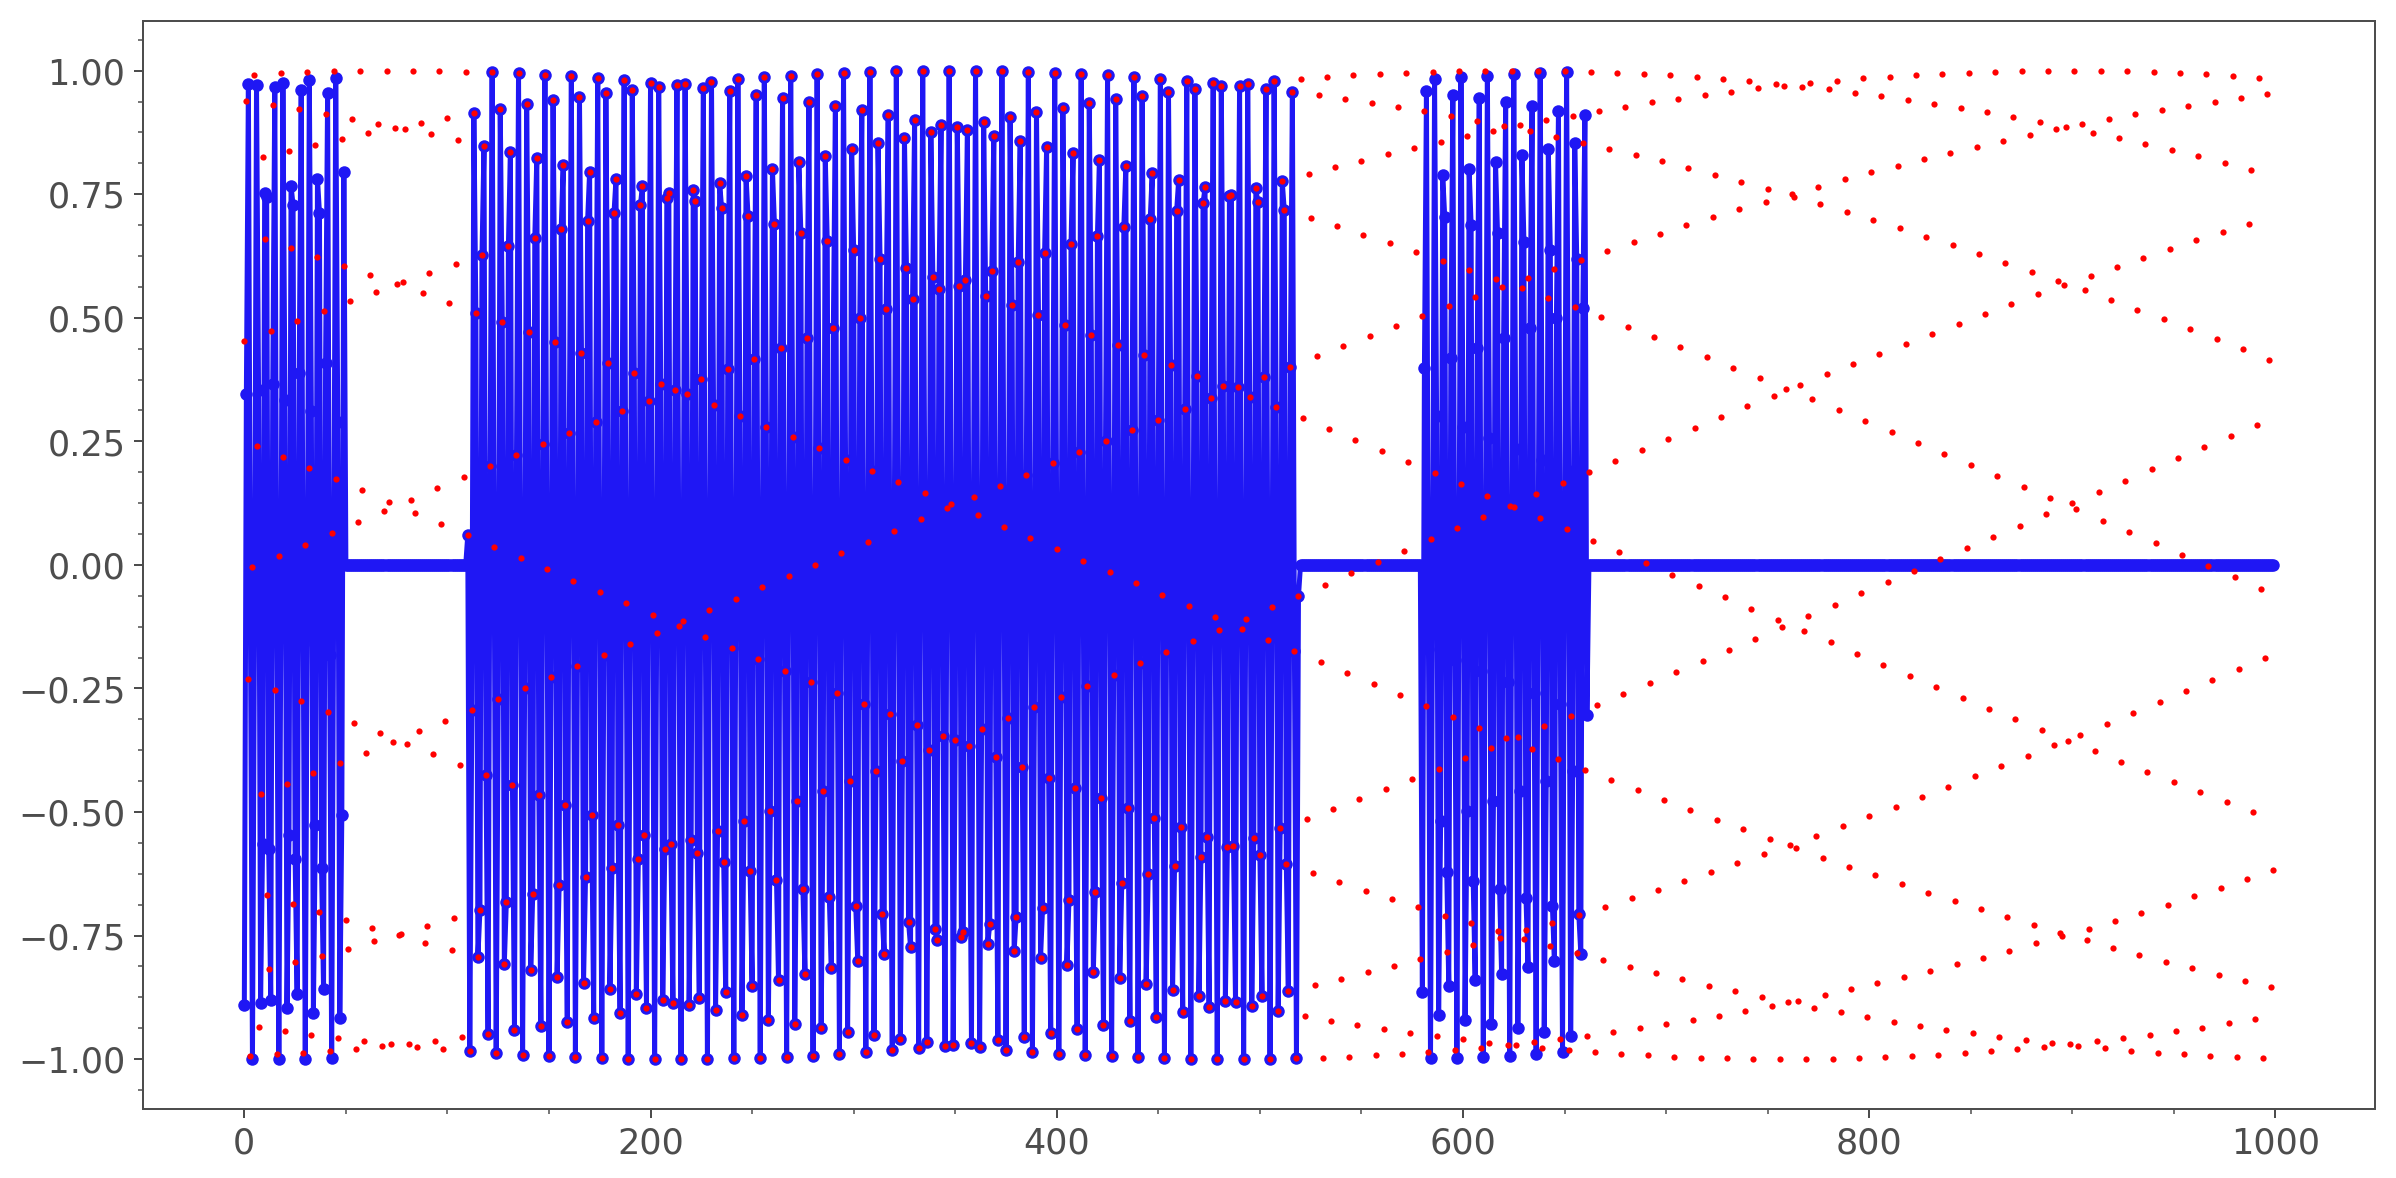

In [463]:
start =146500
stop =start+1000
plt.figure(figsize=(16,8))
sin = wav.sine(200000,90, wav.awg_freq)
plt.plot(pi_pulse_test_form[start:stop])
plt.plot(sin[start:stop], 'r.')
plt.show()

In [190]:
wav.awg_freq

2784918000.0

In [ ]:
cmd = np.array(1000*[0.5])
k = awg.correct_waveform_length(len(cmd))
cmd = cmd[:k]
waveform_cmd = awg.create_waveform(cmd, 1, 1)

In [ ]:
awg.write(f'TRAC1:DEF 1,1000000000')

In [ ]:
awg.write_raw(waveform_cmd)

In [41]:
os.system('cmd /c git commit -a')

1

In [37]:

os.system('cmd /c git commit -m ' + '"notebook test"')

1

In [36]:
'cmd /c git commit -m ' + '"notebook test"'

'cmd /c git commit -m "notebook test"'

In [ ]:
waveform_cmd_2 = waveform_cmd[14:]
waveform_cmd_2 = 'TRAC1:DATA 1,960'.encode('ascii')+ waveform_cmd_2
waveform_cmd_3 = waveform_cmd[14:]
waveform_cmd_3 = 'TRAC1:DATA 1,1920'.encode('ascii')+ waveform_cmd_3
waveforms = [waveform_cmd, waveform_cmd_2, waveform_cmd_3]

In [ ]:
offset = 1
total_len = 0
for waveform in waveforms:
    print(offset, total_len)    
    overcount_val = 16 + offset + int(waveform[offset+15:offset+16].decode('UTF-8'))
    print(waveform[offset+15:offset+16].decode('UTF-8'))
    total_len += int((len(waveform)-overcount_val)/2)
    print((len(waveform)-overcount_val))
    offset = len(str(total_len))
print(offset, total_len)

In [ ]:
list_ = 5050*[1]
list_of_lists = []
max_len = 1000
for i in range(0, len(list_), max_len):
    list_of_lists.append(list_[i:i+max_len])
len(list_of_lists)

In [ ]:
if len(waveform_array) > 1000:
    
    if type(waveform_array) != bytes:
        bytes_array = self.convert_to_bytes(waveform_array, amp)
    else:
        bytes_array = waveform_array
    header = self.create_header(bytes_array, channel)
    cmd = header + bytes_array
    return cmd

In [ ]:
awg.create_upload_waveform(np.array(2000*[0.5]), channel=1)

In [ ]:
awg.query('TRAC1:DATA? 1,0,1000000000')[:10]

In [ ]:
len(hahn_echo_form)

In [ ]:
len(pulsed_odmr_form)

In [ ]:
tau = 1e-9
tau_step = 1e-9
step_number=5
variable_start = tau*1e9
variable_end = (tau+tau_step*(step_number))*1e9
variable_step = tau_step*1e9
np.arange(variable_start,variable_end,variable_step)*1e-9

In [ ]:
sampling_rate = 12e9
samples_ns = sampling_rate/1e9
duration = 3
t = np.linspace(0, round(duration*samples_ns), round(duration*samples_ns)+1)
print(len(t), round(duration*samples_ns)/12)
t

In [ ]:
np.linspace(0,round(duration*samples_ns)-1, round(duration*samples_ns))

In [ ]:
np.linspace(0,5,5+1)

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(pi_pulse_test_form)
plt.show()

In [ ]:
pi_pulse_test_form

In [ ]:
if not ((freq_stop-freq_start)/freq_step)%1 ==0:
    print('yes')

In [18]:
np.arange(0, 5, 1)

array([0, 1, 2, 3, 4])

In [ ]:
#microwave_1._command_wait('OUTP:STAT OFF')

In [ ]:
#microwave_1._command_wait(':POW 4')

In [ ]:
microwave_1._command_wait('OUTP:STAT OFF')

In [ ]:
awg.write(':INIT:CONT 1')
awg.write('OUTP1 on')
awg.write('INIT:IMM')

In [ ]:
len([0.0, 0.9933268043692596, 0.22912808862732423, -0.9404744291317394, -0.44606485848189403, 0.8375818181821408, 0.6392676596394987, -0.6901236238294081, -0.7984566658648987, 0.5059457189378365, 0.9151618378379982, -0.2948477381261342, -0.983173592253333, 0.06806166430735092, 0.9988731978443045, 0.16234579635556343, -0.9614253188058934, -0.3841152529804546, 0.8728224608734545, 0.5854469207571239, -0.7377789551955722, -0.7556284572764836, 0.5634801208475806, 0.8856049388346171, -0.3591999524059978, -0.9684606497323753, 0.13580767444884084, 0.9997870497957888, 0.09481058204683913, -0.9779173415079603, -0.3203842102924882, 0.904015156036075, 0.5289110152488968, -0.7820126393971818, -0.7092958196851962, 0.6184012330393169, 0.8519408101433499, -0.4218862808673449, -0.9492562120111221, 0.20292384018919585, 0.9960641219909513, 0.026835658314376308, -0.9898740110731914, -0.25516730016822176, 0.931015239206195, 0.46992214349260475, -0.8226195308970043, -0.6596736330858233, 0.6704543441709949, 0.8143255781617689, -0.48261599890150647, -0.9256493448041968, 0.26909889236496765, 0.9877216805028856, -0.04126372295855777, -0.9972398752496223, -0.18876698346538745, 0.9536974902791172, 0.40875388215286196, -0.8594113043786432, -0.6069920336361715, 0.7193980440223158, 0.7729336935853748, -0.5411074562038165, -0.8977495312700339, 0.33402592647846474, 0.9747984156345096, -0.10917173268359694, -0.9999807728727281, -0.12149120940613611, 0.9719567142509287, 0.34568991539617916, -0.8922173281555716, -0.5514953463391855, 0.7650053430991502, 0.7279571223458282, -0.5970893830021603, -0.8656861642534665, 0.3974038260494627, 0.9573542624819378, -0.1765734293090883, -0.9980839922969461, -0.05365198738016558, 0.9857082290885, 0.281022719229779, -0.9208854555211831, -0.49344095192033455, 0.8070647253580221, 0.679604455317641, -0.6503021481431445, -0.8296079461918108, 0.4589386591233502, 0.9354701229694624, -0.24315621944575094, -0.9915583303493413, 0.014436060082189122, 0.9948882584650314, 0.21505220506598124, -0.9452827303698317, -0.4330980931557295, 0.8453811291682708, 0.6280999409221586, -0.70049896320094, -0.7896821994675548, 0.5183450414592391, 0.9092474906452283, -0.3086113076020968, -0.9804340515319525, 0.08245715645614574, 0.9994542275398265, 0.14808432880270478, -0.9652960038163017, -0.3707466261867511, 0.879776851962601, 0.5736824451156959, -0.7474470270246023, -0.7460940904060726, 0.5753474600755099, 0.8788079799777796, -0.37263512830608503, -0.964762747662102, 0.15009583572048105, 0.9993849604104985, 0.0804296718712956, -0.9808324589540448, -0.30667572261236914, 0.910092374380179, 0.5166043435846313, -0.7909286054156532, -0.6990457705172819, 0.6296815510151277, 0.8442927623364437, -0.4349307539711628, -0.9446170986015167, 0.21703840541556452, 0.9946807783218797, 0.012402000832143687, -0.9918200413183806, -0.24118252837853643, 0.9361871000803117, 0.4571303512857773, -0.8307420409286422, -0.6487554389639684, 0.6810953254040635, 0.80586191127136, -0.4952092719773375, -0.9200905351840534, 0.2829744014760117, 0.9853634981761624, -0.05568318780178815, -0.9982077930583464, -0.1745707856844166, 0.957940007795636, 0.3955362947599711, -0.8667026881114661, -0.595456330604805, 0.7293503381170964, 0.7636936601295929, -0.553191124580722, -0.8912968059052239, 0.3475980280907962, 0.9714763313511752, -0.12351013076428473, -0.9999660892673559, -0.1071494242966957, 0.9752502126005509, 0.33210783291274354, -0.8986437698480226, -0.5393956343054254, 0.7742227936308352, 0.7179835754503306, -0.6086074054372216, -0.8583694493831333, 0.4106095759130839, 0.95308368329609, -0.19076426247247924, -0.9970867753766267, -0.039231128805331895, 0.9880374337920469, 0.2671391321947956, -0.9264171508316766, -0.4808333465338353, 0.8155045839352778, 0.6689436499727708, -0.6612011067277475, -0.8214611750374506, 0.4717168120424621, 0.9302708548338965, -0.2571336739088217, -0.9895832049741623, 0.028869111535143568, 0.9962423672129288, 0.20093150232629534, -0.9498940245823615, -0.4200410655573901, 0.8530042536904311, 0.6168013194630898, -0.7107283111005758, -0.7807431548585646, 0.5306363353331734, 0.9031436465560626, -0.3223105591826801, -0.9774901778739328, 0.09683546365208866, 0.9998269602907133, 0.13379199889273438, -0.9689655108210237, -0.3573007318330627, 0.8865478881514893, 0.5617984079203793, -0.7569593229034072, -0.7364042295518543, 0.5870948907425824, 0.8718278681439371, -0.38599264306220804, -0.9608637787224421, 0.16435271541552215, 0.998774588516581, 0.06603199929242054, -0.9835431604311233, -0.2929033204334764, 0.9159799197450604, 0.5041900060529461, -0.7996797334581514, -0.6886500327383617, 0.6408306366247571, 0.8364687548928529, -0.44788458285669525, -0.939781116891125, 0.23110773751820263, 0.9930901325460137, -0.0020342413596329254, -0.9935593656649456, -0.22714749157181457, 0.941163849555441, 0.44424328822729503, -0.8386914154387828, -0.6377020372737615, 0.6915943590907625, 0.7972302941444129, -0.5076993381474104, -0.9143399688611269, 0.2967909356969611, 0.9827999555634176, -0.07009104767342961, -0.9989676736927042, -0.16033820548560135, 0.9619828803746703, 0.3822362733751866, -0.8738134417395323, -0.5837965281090626, 0.7391506278050591, 0.7542944647515468, -0.5651595020139322, -0.8846583247585903, 0.3610976865584816, 0.9679517810158492, -0.1378227880134658, -0.9997430020398931, -0.09278530810196242, 0.9783404583809782, 0.3184565356068517, -0.9048829245728356, -0.5271835064556332, 0.7832788878562937, 0.7078603931028898, -0.6199985875833111, -0.8508738411440361, 0.4237297503519072, 0.9486144712827024, -0.204915338324378, -0.9958817549140091, -0.024802094043839176, 0.9901607209328183, 0.2531998705090239, -0.9317557709050627, -0.46812553033809934, 0.8237744826399546, 0.658143429620585, -0.6719622639338529, -0.8131432025932119, 0.4843966541355757, 0.9248777083081098, -0.27105753896563245, -0.9874018398809705, 0.04329614635668755, 0.9973888484022206, 0.18676892331364936, -0.9543073507263147, -0.4068964969109808, 0.8604496030079613, 0.6053741500157551, -0.720809535622923, -0.7716413950303685, 0.5428170389225897, 0.8968515776768461, -0.33594263779738015, -0.974342584814005, 0.11119358930234517, 0.9999913184154748, 0.1194717853000881, -0.9724330750555826, -0.34378037218753854, 0.8931341582837764, 0.5497972859314887, -0.766313860367858, -0.7265608941844792, 0.5987199645587028, 0.8646660580630269, -0.3992697128253631, -0.9567645555001748, 0.17857534224785843, 0.9979560613220679, 0.0516205649390472, -0.9860488810000275, -0.27906987407163003, 0.9216765651033678, 0.49167058993446067, -0.808264199696094, -0.6781107729313494, 0.6518461662795652, 0.8284704184193518, -0.46074506780754554, -0.9347492747502194, 0.2451289042979825, 0.9912925161709412, -0.01647005959373685, -0.9950916216191034, -0.21306511479973955, 0.9459444504238077, 0.43126364011877877, -0.8464659976927804, -0.6265157316623463, 0.7019492571202641, 0.78843252570223, -0.520083594348386, -0.908398844314875, 0.3105456155143521, 0.9800315869343523, -0.0844842998215012, -0.9995193587854483, -0.14607220909083543, 0.9658252654383817, 0.36885658986516145, -0.8807420833057268, -0.5720150561763986, 0.7487968706010545, 0.7447380663440527, -0.5770100941657251, -0.8778354713605793, 0.37452208840829937, 0.9642254991824879, -0.15210672152029078, -0.9993115576841006, -0.07840185445708361, 0.9812268075519626, 0.3047388685548679, -0.9109334920234547, -0.5148615079278667, 0.7921717383887376, 0.6975896850828279, -0.6312605553963261, -0.8432009017011006, 0.43676161498129334, 0.9439475578733603, -0.21902370762939322, -0.9944691820482335, -0.010367890260826945, 0.9920776479950655, 0.23920783926372569, -0.9369002031157944, -0.45532015177778595, 0.831872697936785, 0.647206045142474, -0.6825833770212051, -0.8046557624135318, 0.4969755427879344, 0.9192918073814557, -0.2849249127339213, -0.9850146896895456, 0.05771415779846199, 0.9983274630939627, 0.1725674196610395, -0.9585217890173723])

In [ ]:
awg.get_amplitude()

In [ ]:
#awg.write('DC:VOLT:AMPL 0.1')
awg.query('DC:VOLT:AMPL?')

In [ ]:
awg.query('INIT:CONT?')

In [ ]:
16*np.int16(0.89532947517898*2047)

In [ ]:
16*np.int16(0.906489224154323*2047)

In [ ]:
pulsed_odmr_form[30*132985:30*132985+50]

In [ ]:
pulsed_odmr_form[132985:133035]

In [ ]:
pulsed_odmr_form[0:50]

In [ ]:
t_sin = np.linspace(0,10000,1)
test_sin = np.sin

In [ ]:
#t = np.linspace(0,len(pulsed_odmr_form), len(pulsed_odmr_form))/12
start = 0
stop = 100
#plt.plot(t[start:stop],pulsed_odmr_form[start:stop])
plt.plot(t[start:stop], test_sin[start:stop])
plt.show()

In [ ]:
awg.write('INIT:IMM')

In [ ]:
awg.query('TRAC1:DATA? 1,0,24000')

In [ ]:
bytes_ = awg.create_waveform(sin)

In [ ]:
len(bytes_)

In [ ]:
2*(24000001.5+11)

In [ ]:
wave = awg.create_waveform(sin)

In [ ]:
len(wave)-17-int(wave[16:17].decode('UTF-8'))

In [ ]:
wave[16:17].decode('UTF-8')

In [ ]:
sampling_rate = 12e9

In [ ]:
def sine(duration, freq, phase):
        duration = int(duration)
        samples_ns = sampling_rate/1e9
        t = np.linspace(0, duration*samples_ns, duration*samples_ns)
        freq = 2*np.pi*freq/samples_ns*1e-9
        phase = np.radians(phase)
        return np.sin(freq*t+phase).tolist()
    
def zero(duration, offset=0):
        if offset < -1 or offset > 1:
            raise ValueError('offset must be between -1 and 1')
        if duration < 0:
            raise ValueError('duration cannot be negative')
        samples_ns = sampling_rate/1e9
        duration = int(duration*samples_ns)
        return duration * [offset]

In [ ]:
sin = sine(2000, 1e6, 0)
t = np.linspace(0,2000*12,2000*12)
zer = zero(2000)

In [ ]:
plt.plot(t/12, zer)
plt.show()

In [ ]:
freq_start = 90
freq_stop = 110
freq_step = 3

In [ ]:
list_ = np.arange(freq_start, freq_stop+freq_step, freq_step)

In [ ]:
for freq in list_:
    print(freq)